<a href="https://colab.research.google.com/github/HelgaHanemer/SF-Data-Science/blob/Initial-commit/NLP_project/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Обработка естественного языка (NLP) в медицине**


Установим и импортируем необходимые библиотеки

In [9]:
!pip -q install transformers torch pandas seaborn nltk scikit-learn textblob tqdm

In [10]:
# -*- coding: utf-8 -*-
from __future__ import annotations

# ---- runtime/env tweaks (до third-party импортов)
import os
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")

# ---- stdlib
import json
import math
import random
from collections import defaultdict
from typing import Any, Dict, List, Optional, Tuple

# ---- third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import torch
from tqdm.auto import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from textblob import TextBlob

from transformers import (
    BertTokenizer,               # при желании позже сменим на AutoTokenizer
    BertForSequenceClassification,
    pipeline,
)
from torch.utils.data import DataLoader


def set_seed(seed: int = 42, deterministic_torch: bool = True) -> None:
    """
    Зафиксировать генераторы случайных чисел для воспроизводимости.

    Parameters
    ----------
    seed : int, default=42
        Начальное значение генератора случайных чисел.
    deterministic_torch : bool, default=True
        Включить детерминизм для операций PyTorch (cuDNN).
    """
    random.seed(seed)
    np.random.seed(seed)
    try:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        if deterministic_torch and hasattr(torch.backends, "cudnn"):
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False
    except Exception:
        # torch может быть недоступен в окружении — просто пропускаем
        pass


def get_device() -> str:
    """
    Определить доступное устройство для PyTorch.

    Returns
    -------
    str
        "cuda" если доступна GPU, иначе "cpu".
    """
    try:
        return "cuda" if torch.cuda.is_available() else "cpu"
    except Exception:
        return "cpu"


def configure_pandas() -> None:
    """
    Удобное отображение DataFrame в ноутбуке.
    """
    pd.set_option("display.max_rows", 100)
    pd.set_option("display.max_columns", 100)
    pd.set_option("display.width", 120)
    pd.set_option("display.float_format", lambda x: f"{x:,.4f}")


def set_plot_style() -> None:
    """
    Единый аккуратный стиль для всех графиков (Seaborn + Matplotlib).
    """
    sns.set_theme(style="whitegrid", context="notebook")
    plt.rcParams.update({
        "figure.figsize": (9, 5),
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
    })


def ensure_nltk_data() -> None:
    """
    Проверить и при необходимости скачать ресурсы NLTK/TextBlob.
    Без падений, если какой-то ресурс недоступен.
    """
    resources = [
        ("tokenizers/punkt", "punkt"),
        ("tokenizers/punkt_tab", "punkt_tab"),  # актуально для NLTK>=3.8
        ("corpora/stopwords", "stopwords"),
        ("corpora/wordnet", "wordnet"),
        ("corpora/omw-1.4", "omw-1.4"),
        ("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger"),
    ]
    for path, name in resources:
        try:
            nltk.data.find(path)
        except LookupError:
            try:
                nltk.download(name, quiet=True)
            except Exception:
                pass

    # Лёгкий пакет корпусов для TextBlob (если доступно)
    try:
        from textblob import download_corpora as tb_data
        tb_data.download_lite()
    except Exception:
        pass


# --- применяем базовые настройки окружения
set_seed(42)
configure_pandas()
set_plot_style()
ensure_nltk_data()

# Удобный вывод используемого устройства (для логов/отчёта)
DEVICE = get_device()
print(f"PyTorch device: {DEVICE}")


PyTorch device: cuda


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [11]:
# Задание 1.3 — чтение TSKV → pandas.DataFrame

from typing import Dict, Optional
from IPython.display import display

def _parse_tskv_line(line: str) -> Dict[str, str]:
    """
    Разобрать одну строку TSKV (формат: key1=val1\\tkey2=val2...).

    Игнорируются:
      - пустые строки;
      - комментарии, начинающиеся с '#'.

    Из значений разворачиваются экранированные последовательности:
      '\\t' → табуляция, '\\n' и '\\r\\n' → перевод строки.

    Parameters
    ----------
    line : str
        Исходная строка из TSKV-файла.

    Returns
    -------
    Dict[str, str]
        Словарь {ключ: значение} для одной записи; пустой словарь, если строка пропущена.
    """
    line = line.strip()
    if not line or line.startswith("#"):
        return {}

    row: Dict[str, str] = {}
    for item in line.split("\t"):
        if "=" not in item:
            continue
        key, val = item.split("=", 1)
        # Нормализуем распространённые экранирования
        val = (
            val.replace("\\r\\n", "\n")
               .replace("\\n", "\n")
               .replace("\\t", "\t")
        )
        row[key] = val
    return row


def _auto_cast_columns(
    df: pd.DataFrame,
    frac_threshold: float = 0.85,
) -> pd.DataFrame:
    """
    Аккуратно привести типы столбцов:
    1) числовые строки → числа (если >= frac_threshold значений конвертируются);
    2) строки-даты → datetime (если >= frac_threshold значений конвертируются);
    3) опционально булевы ('true/false', '1/0', 'yes/no') → boolean.

    Parameters
    ----------
    df : pd.DataFrame
        Исходная таблица.
    frac_threshold : float, default=0.85
        Минимальная доля успешно распознанных значений, чтобы применять приведение типа.

    Returns
    -------
    pd.DataFrame
        Таблица с обновлёнными типами.
    """
    for col in df.columns:
        s = df[col]

        # 1) numeric
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().mean() >= frac_threshold:
            df[col] = s_num
            continue

        # 2) datetime
        s_dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
        if s_dt.notna().mean() >= frac_threshold:
            df[col] = s_dt
            continue

        # 3) boolean (часто полезно)
        if s.dtype == "object":
            sl = s.astype(str).str.strip().str.lower()
            mapping = {"true": True, "false": False, "1": True, "0": False, "yes": True, "no": False}
            s_bool = sl.map(mapping)
            if s_bool.notna().mean() >= frac_threshold:
                df[col] = s_bool.astype("boolean")

    return df


def load_tskv(
    path: str,
    limit: Optional[int] = None,
    encoding: str = "utf-8",
) -> pd.DataFrame:
    """
    Загрузить TSKV-файл в pandas.DataFrame.

    Parameters
    ----------
    path : str
        Путь к .tskv файлу.
    limit : int, optional
        Если задано, читать только первые N непустых (не-комментариев) строк —
        удобно для быстрого превью больших файлов.
    encoding : str, default="utf-8"
        Кодировка входного файла.

    Returns
    -------
    pd.DataFrame
        Таблица с данными.
    """
    rows: List[Dict[str, str]] = []
    with open(path, "r", encoding=encoding, errors="replace") as f:
        for line in f:
            row = _parse_tskv_line(line)
            if row:
                rows.append(row)
                if limit is not None and len(rows) >= limit:
                    break

    df = pd.DataFrame(rows)
    if not df.empty:
        df = _auto_cast_columns(df)
    return df


def peek(df: pd.DataFrame, n: int = 5) -> None:
    """
    Короткое превью: форма, типы, пропуски и первые строки.
    """
    print("Форма:", df.shape)
    print("\nТипы:")
    print(df.dtypes)
    print("\nПропуски (шт.):")
    print(df.isna().sum())
    display(df.head(n))


# === Использование ===
# В Colab обычно: "/content/geo-reviews-dataset-2023.tskv"
# Здесь у меня файл доступен по пути "/mnt/data/geo-reviews-dataset-2023.tskv".
DATA_PATH = "/content/geo-reviews-dataset-2023.tskv"

df = load_tskv(DATA_PATH, limit=None)
peek(df, n=5)  # df готов к дальнейшей работе


/tmp/ipython-input-2778823580.py:78: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s_dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-2778823580.py:78: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  s_dt = pd.to_datetime(s, errors="coerce", infer_datetime_format=True)
/tmp/ipython-input-2778823580.py:78: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  s_dt = pd.to_datetime(s, errors="

Форма: (500000, 5)

Типы:
address     object
name_ru     object
rating     float64
rubrics     object
text        object
dtype: object

Пропуски (шт.):
address      0
name_ru    970
rating       0
rubrics      0
text         0
dtype: int64


,address,name_ru,rating,rubrics,text
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0000,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0000,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0000,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0000,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0000,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...


In [12]:
# Задание 1.4 — фильтрация по больницам г. Москвы (address + rubrics)

from IPython.display import display
import re

# --- Проверки наличия нужных столбцов
if "df" not in globals():
    raise NameError("DataFrame 'df' не найден. Сначала выполните задание 1.3 (чтение TSKV).")

required_cols = {"address", "rubrics"}
missing = required_cols.difference(df.columns)
if missing:
    raise KeyError(f"В датасете отсутствуют необходимые столбцы: {sorted(missing)}")

# === Адреса (векторизовано)
addr = df["address"].astype(str).str.casefold()

# Москва (учитываем 'москва' / 'moscow' с границами слова; 'мск' не используем — слишком шумно)
mask_addr_moscow_like = addr.str.contains(r"\bмосква\b|\bmoscow\b", regex=True, na=False)

# Исключения: Московская область / Moscow Oblast/Region (разные написания/сокращения)
mask_addr_oblast = addr.str.contains(
    r"московск(?:ая|\.)?\s*обл(?:асть)?\.?|\bmoscow\s+(?:oblast|region)\b",
    regex=True, na=False
)

# Включим «Новую Москву» (ТиНАО): иногда адрес содержится без слова «Москва»
# Примеры: "Троицк, Москва" обычно уже ловится, но на всякий случай расширим правило:
mask_tinao_cities = addr.str.contains(
    r"\b(троицк|щербинка|мосрентген|филимонковское|десеновское|сосенское|внуковское|новофедоровское|роговское)\b",
    regex=True, na=False
)
# и только в сочетании с отсутствием "область"
mask_moscow = (mask_addr_moscow_like | mask_tinao_cities) & ~mask_addr_oblast

# === Рубрики (векторизовано, поддержка list/tuple/set)
def _rubric_to_text(x) -> str:
    if isinstance(x, (list, tuple, set)):
        return " | ".join(map(str, x))
    return str(x)

rub = df["rubrics"].apply(_rubric_to_text).astype(str).str.casefold()

# Ключи для «больницы»: учитываем морфологию «больниц…», но исключаем «больничн…»
# Также учитываем частые аббревиатуры и английский «hospital».
hospital_regex = re.compile(
    r"(?:\bклиническ\w*\s+больниц\w*\b|\bгородск\w*\s+больниц\w*\b|\bстационар\w*\b|\bгкб\b|\bдгкб\b|\bцкб\b|\bhospital\b|"
    r"\bбольниц(?!н)\w*\b)",  # 'больничн...' исключаем (?!н)
    flags=re.IGNORECASE
)

mask_hospital = rub.str.contains(hospital_regex, na=False)

# === Итоговый фильтр
df_hosp_msk = df[mask_moscow & mask_hospital].copy()

# Удобный порядок столбцов для просмотра
cols_pref = [c for c in ("name", "title", "address", "rubrics") if c in df_hosp_msk.columns]
cols_pref += [c for c in df_hosp_msk.columns if c not in cols_pref]
df_hosp_msk = df_hosp_msk[cols_pref]

# Небольшая сводка по фильтрам — удобно для отчёта
print("— адрес «Москва/ТиНАО», исключая область:", int(mask_moscow.sum()))
print("— метятся как «больница/стационар»:", int(mask_hospital.sum()))
print(f"Найдено записей (больницы Москвы): {len(df_hosp_msk)}")

display(df_hosp_msk.head(10))

# Результат доступен как df_hosp_msk


/tmp/ipython-input-524812562.py:29: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_tinao_cities = addr.str.contains(


— адрес «Москва/ТиНАО», исключая область: 104852
— метятся как «больница/стационар»: 3283
Найдено записей (больницы Москвы): 930


,address,rubrics,name_ru,rating,text
1055,"Москва, 11-я Парковая улица, 32, корп. 4",Больница для взрослых,"ГКБ им. Д. Д. Плетнёва, пульмонологическое отд...",5.0000,Опытные специалисты! Уважительное отношение к ...
1255,"Москва, Погодинская улица, 1с1","Больница для взрослых;Медцентр, клиника;Специа...",Клиника колопроктологии и малоинвазивной хирургии,5.0000,Самая лучшая клиника!\nСамые лучшие врачи и ме...
1256,"Москва, Погодинская улица, 1с1","Больница для взрослых;Медцентр, клиника;Специа...",Клиника колопроктологии и малоинвазивной хирургии,5.0000,"Лучшие специалисты, лечат мою мамочку👍Админист..."
2109,"Москва, Троицк, Юбилейная улица, 5",Стоматологическая поликлиника;Больница для взр...,"Троицкая центральная городская больница, стома...",5.0000,За весь персонал ничего не могу сказать. А вот...
4636,"Москва, улица Матросская Тишина, 14",Детская поликлиника;Детская больница,"Детская поликлиника № 52, филиал № 1",5.0000,"Все чистое, новое, вежливый персонал.\n"
4637,"Москва, улица Матросская Тишина, 14",Детская поликлиника;Детская больница,"Детская поликлиника № 52, филиал № 1",5.0000,Оборудование и здание после ремонта шикарные! ...
4768,"Москва, Варшавское шоссе, 170Гк1",Наркологическая клиника;Медицинская реабилитац...,Московский научно-практический центр наркологи...,5.0000,Благодаря этой больничке я уже год как трезвый...
5947,"Москва, Минусинская улица, 3",Больница для взрослых;Детская больница,Профмедпомощь,5.0000,Огромное СПАСИБО за Ваш труд Ольга Сергеевна (...
6260,"Москва, Новосущёвская улица, 21","Медцентр, клиника;Диагностический центр;Специа...",Клиника Лор центр,5.0000,Хочу выразить огромную благодарность Рубену Га...
6719,"Москва, улица Россолимо, 11с5","Больница для взрослых;Медцентр, клиника;Диагно...","Клиника ревматологии, нефрологии и профпатолог...",5.0000,Поздравляю весь персонал клиники С Новым Годом...


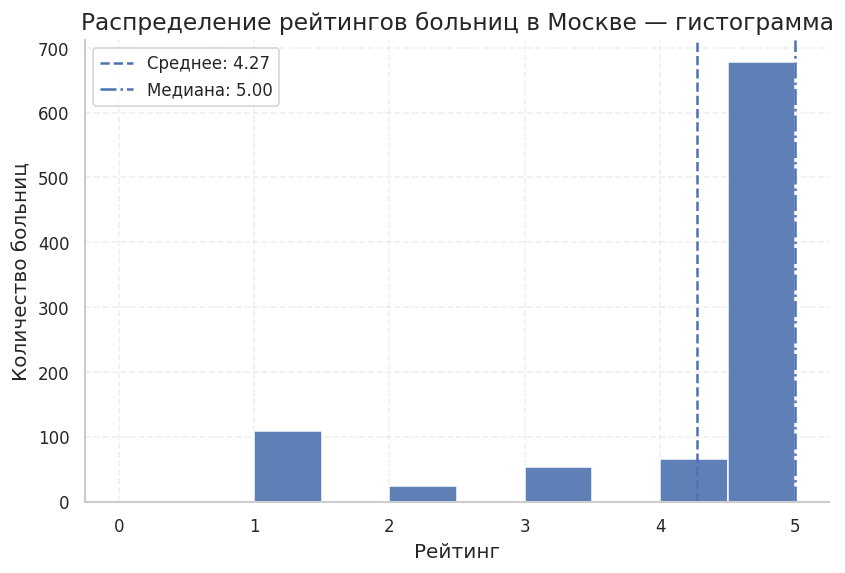

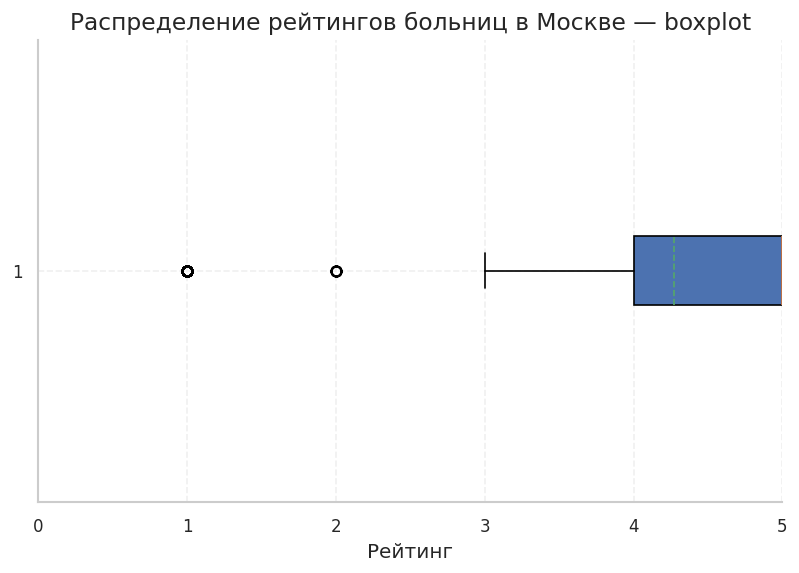

Сводка по рейтингам: {'count': 930, 'mean': 4.269892473118279, 'std': 1.369063459812533, 'min': 1.0, '25%': 4.0, '50% (median)': 5.0, '75%': 5.0, 'max': 5.0, 'in_[0,5]': 930, 'out_of_[0,5]': 0, 'tukey_low_fence': 2.5, 'tukey_high_fence': 6.5, 'n_outliers_tukey': 133}
Вывод: по 930 учреждениям средний рейтинг ≈ 4.27, медиана ≈ 5.00, диапазон 1.00–5.00. В диапазоне [0,5]: 930, вне диапазона: 0. По критерию Тьюки выбросов: 133 (границы 2.50 / 6.50).


In [13]:
# Задание 1.5 — график распределения рейтингов больниц (Москва)
# (без повторных импортов — используем уже импортированные np/pd/plt)

def use_plot_style() -> None:
    """
    Единый нейтральный стиль графиков (matplotlib).
    """
    plt.rcParams.update({
        "figure.figsize": (8, 5),
        "figure.dpi": 120,
        "savefig.dpi": 150,
        "axes.grid": True,
        "grid.linestyle": "--",
        "grid.alpha": 0.3,
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
    })

def finalize_axes(ax, title: str = "", xlabel: str = "", ylabel: str = "") -> None:
    """
    Унифицированные подписи и оформление осей (+ скрываем верхнюю/правую рамки).
    """
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for side in ("top", "right"):
        ax.spines[side].set_visible(False)

def detect_rating_column(df: pd.DataFrame) -> str:
    """
    Определить столбец с рейтингом по типичным названиям.
    """
    candidates = [
        "rating", "ratings", "avg_rating", "average_rating",
        "score", "stars", "rating_value", "review_rating",
        "оценка", "рейтинг"
    ]
    lower_map = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c in lower_map:
            return lower_map[c]
    for key in ("rating", "score", "star", "оцен", "рейти"):
        for c in df.columns:
            if key in c.lower():
                return c
    raise KeyError("Не найден столбец с рейтингом.")

# --- Проверки наличия данных из Задания 1.4
if "df_hosp_msk" not in globals():
    raise NameError("DataFrame 'df_hosp_msk' не найден. Сначала выполните Задание 1.4.")
if df_hosp_msk.empty:
    raise ValueError("Отфильтрованный DataFrame пуст. Проверьте фильтры по address/rubrics.")

# --- Поиск столбца рейтинга и подготовка данных
rating_col = detect_rating_column(df_hosp_msk)
ratings_raw = df_hosp_msk[rating_col].astype(str).str.replace(",", ".", regex=False)
ratings = pd.to_numeric(ratings_raw, errors="coerce").dropna()
if ratings.empty:
    raise ValueError(f"Столбец '{rating_col}' не содержит числовых значений рейтинга.")

# Оценим попадание в диапазон «звёзд» [0,5]
in_0_5 = ratings.between(0, 5)
n_total = int(ratings.size)
n_in = int(in_0_5.sum())
n_out = n_total - n_in
use_fixed_bins = (n_in / max(n_total, 1) >= 0.8)
bins = np.linspace(0, 5, 11) if use_fixed_bins else "auto"

# --- Гистограмма
use_plot_style()
fig, ax = plt.subplots()
ax.hist(ratings.values, bins=bins, alpha=0.9)

mean_r = float(ratings.mean())
med_r  = float(ratings.median())
ax.axvline(mean_r, linestyle="--", linewidth=1.5, label=f"Среднее: {mean_r:.2f}")
ax.axvline(med_r,  linestyle="-.", linewidth=1.5, label=f"Медиана: {med_r:.2f}")
ax.legend()

finalize_axes(
    ax,
    title="Распределение рейтингов больниц в Москве — гистограмма",
    xlabel="Рейтинг",
    ylabel="Количество больниц"
)
plt.show()

# --- Бокс-плот (горизонтально)
fig2, ax2 = plt.subplots()
bp = ax2.boxplot(
    ratings.values,
    vert=False,
    patch_artist=True,  # заливка бокса
    showmeans=True,
    meanline=True
)
# опционально ограничим ось X, если большинство значений в [0,5]
if use_fixed_bins:
    ax2.set_xlim(0, 5)

finalize_axes(
    ax2,
    title="Распределение рейтингов больниц в Москве — boxplot",
    xlabel="Рейтинг",
    ylabel=""  # ось Y здесь категориальная, можно не подписывать
)
plt.show()

# --- Короткая сводка и выводы (+ оценка выбросов по Тьюки)
q1 = float(ratings.quantile(0.25))
q3 = float(ratings.quantile(0.75))
iqr = q3 - q1
low_fence  = q1 - 1.5 * iqr
high_fence = q3 + 1.5 * iqr
n_outliers = int(((ratings < low_fence) | (ratings > high_fence)).sum())

summary = {
    "count": int(ratings.count()),
    "mean": mean_r,
    "std": float(ratings.std(ddof=1)) if ratings.size > 1 else float("nan"),
    "min": float(ratings.min()),
    "25%": q1,
    "50% (median)": med_r,
    "75%": q3,
    "max": float(ratings.max()),
    "in_[0,5]": n_in,
    "out_of_[0,5]": n_out,
    "tukey_low_fence": round(low_fence, 3),
    "tukey_high_fence": round(high_fence, 3),
    "n_outliers_tukey": n_outliers,
}
print("Сводка по рейтингам:", summary)

print(
    f"Вывод: по {summary['count']} учреждениям средний рейтинг ≈ {mean_r:.2f}, "
    f"медиана ≈ {med_r:.2f}, диапазон {summary['min']:.2f}–{summary['max']:.2f}. "
    f"В диапазоне [0,5]: {n_in}, вне диапазона: {n_out}. "
    f"По критерию Тьюки выбросов: {n_outliers} (границы {low_fence:.2f} / {high_fence:.2f})."
)


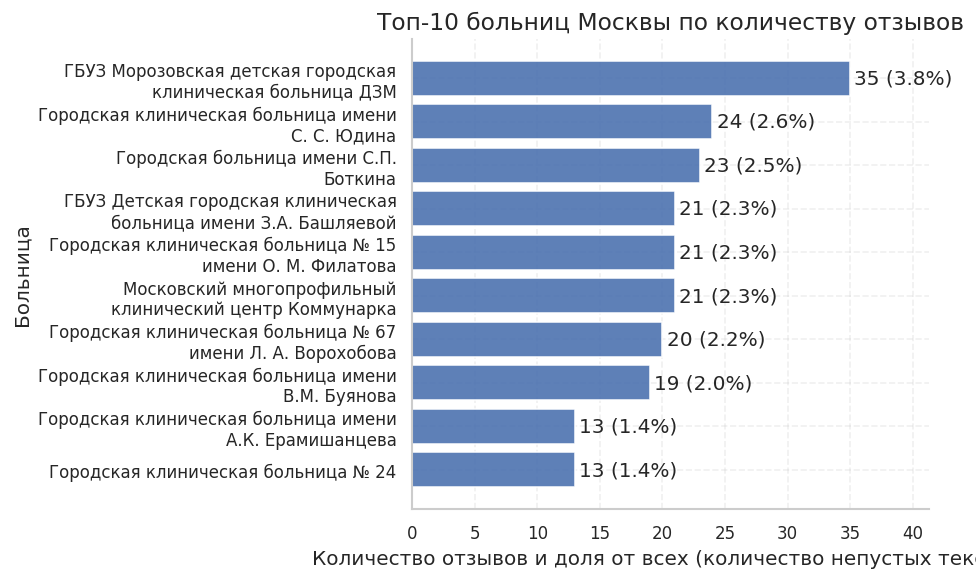

,hospital,reviews_count,share_%_of_all,cum_share_%_of_all
0,ГБУЗ Морозовская детская городская клиническая...,35,3.8000,3.8000
1,Городская клиническая больница имени С. С. Юдина,24,2.6000,6.3000
2,Городская больница имени С.П. Боткина,23,2.5000,8.8000
3,ГБУЗ Детская городская клиническая больница им...,21,2.3000,11.1000
4,Городская клиническая больница № 15 имени О. М...,21,2.3000,13.3000
5,Московский многопрофильный клинический центр К...,21,2.3000,15.6000
6,Городская клиническая больница № 67 имени Л. А...,20,2.2000,17.7000
7,Городская клиническая больница имени В.М. Буянова,19,2.0000,19.8000
8,Городская клиническая больница имени А.К. Ерам...,13,1.4000,21.2000
9,Городская клиническая больница № 24,13,1.4000,22.6000


In [14]:
# Задание 1.6 — Топ-10 больниц Москвы по количеству отзывов (группировка ТОЛЬКО по name_ru)
# (добавлены подписи с % от всех отзывов и таблица с кумулятивной долей)

# --- проверки ---
if "df_hosp_msk" not in globals():
    raise NameError("DataFrame 'df_hosp_msk' не найден. Выполните Задание 1.4.")
if df_hosp_msk.empty:
    raise ValueError("Отфильтрованный DataFrame пуст.")
if "name_ru" not in df_hosp_msk.columns:
    raise KeyError("В датасете нет столбца 'name_ru'. Покажи df_hosp_msk.columns.tolist(), подстрою код.")
name_col = "name_ru"

# аккуратно нормализуем пробелы в name_ru (без изменения регистра)
name_norm = (
    df_hosp_msk[name_col]
    .astype(str)
    .str.strip()
    .str.replace(r"\s+", " ", regex=True)
)
df_tmp = df_hosp_msk.assign(**{name_col: name_norm})

# возможные идентификаторы отзывов
review_id_col = next((c for c in ("review_id", "reviewId", "reviewID", "id_review") if c in df_tmp.columns), None)

# --- агрегация количества отзывов на больницу ---
if review_id_col is not None:
    agg = (
        df_tmp.groupby(name_col, dropna=False)[review_id_col]
        .nunique(dropna=True)
        .reset_index(name="reviews")
    )
    method_note = f"уникальные '{review_id_col}'"
elif "text" in df_tmp.columns:
    has_text = df_tmp["text"].notna() & df_tmp["text"].astype(str).str.strip().ne("")
    agg = (
        df_tmp.assign(_has_text=has_text)
             .groupby(name_col, dropna=False)["_has_text"]
             .sum()
             .astype(int)
             .reset_index(name="reviews")
    )
    method_note = "количество непустых текстов"
else:
    agg = (
        df_tmp.groupby(name_col, dropna=False)
             .size()
             .reset_index(name="reviews")
    )
    method_note = "количество строк (отзывов)"

# --- доля от всех отзывов (по всему df_tmp, не только топ-10)
total_reviews = int(agg["reviews"].sum()) or 1  # защита от деления на ноль
agg["share_pct"] = agg["reviews"] / total_reviews * 100

# --- топ-10 (как раньше)
top10_idx = agg["reviews"].nlargest(10).index
top10 = agg.loc[top10_idx].sort_values("reviews", ascending=False).reset_index(drop=True)

# кумулятивная доля для топ-10 в порядке убывания
top10["cum_share_pct"] = top10["share_pct"].cumsum()

# --- стиль/построение ---
try:
    use_plot_style()
except NameError:
    pass
try:
    finalize_axes
except NameError:
    def finalize_axes(ax, title="", xlabel="", ylabel=""):
        ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)

labels = top10[name_col].astype(str).tolist()
values = top10["reviews"].astype(int).to_numpy()
shares = top10["share_pct"].to_numpy()

# мини-обёртка длинных подписей без новых импортов
def _wrap_label(text: str, width: int = 36) -> str:
    words, lines, cur = text.split(), [], ""
    for w in words:
        if len(cur) + (1 if cur else 0) + len(w) <= width:
            cur = f"{cur} {w}".strip()
        else:
            if cur: lines.append(cur)
            cur = w
    if cur: lines.append(cur)
    return "\n".join(lines)

wrapped_labels = [_wrap_label(s) for s in labels]

fig, ax = plt.subplots()
y_pos = range(len(values))
bars = ax.barh(list(y_pos), values, alpha=0.9)

# подписи по оси Y
ax.set_yticks(list(y_pos))
ax.set_yticklabels(wrapped_labels)
ax.invert_yaxis()

# подписи значений: "число (доля %)"
x_pad = (max(values) * 0.01) if values.size else 0.5
for i, (bar, v, p) in enumerate(zip(bars, values, shares)):
    # красивый формат числа с пробелом как разделителем тысяч
    v_str = f"{v:,.0f}".replace(",", " ")
    ax.text(bar.get_width() + x_pad, i, f"{v_str} ({p:.1f}%)", va="center")

# запас справа, чтобы подписи не срезались
ax.set_xlim(0, max(values) * 1.18 if values.size else 1)

finalize_axes(
    ax,
    title="Топ-10 больниц Москвы по количеству отзывов",
    xlabel=f"Количество отзывов и доля от всех ({method_note})",
    ylabel="Больница",
)
plt.tight_layout()
plt.show()

# --- таблица результата: доля и кумулятивная доля
top10_table = (
    top10[[name_col, "reviews", "share_pct", "cum_share_pct"]]
    .rename(columns={name_col: "hospital",
                     "reviews": "reviews_count",
                     "share_pct": "share_%_of_all",
                     "cum_share_pct": "cum_share_%_of_all"})
)

# округляем проценты до 1 знака и выводим
top10_table["share_%_of_all"] = top10_table["share_%_of_all"].round(1)
top10_table["cum_share_%_of_all"] = top10_table["cum_share_%_of_all"].round(1)

display(top10_table)


In [15]:
# Задание 2 — Сентимент-анализ на базе BERT (nlptown)

def load_bert_sentiment(
    model_name: str = "nlptown/bert-base-multilingual-uncased-sentiment",
    max_length: int = 256
):
    """
    Загрузить предобученные токенизатор и модель для сентимент-анализа
    (метки '1 star' ... '5 stars') и инициализировать pipeline.

    Parameters
    ----------
    model_name : str
        Имя модели на HuggingFace Hub.
    max_length : int
        Максимальная длина токенов для усечения (truncation).

    Returns
    -------
    dict
        {"tokenizer": BertTokenizer, "model": BertForSequenceClassification, "pipeline": transformers.Pipeline}
    """
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name)

    # Выбор устройства: GPU при наличии
    device = 0 if torch.cuda.is_available() else -1

    # Pipeline (сразу задаём общие параметры препроцессинга)
    clf = pipeline(
        task="text-classification",
        model=model,
        tokenizer=tokenizer,
        device=device,
        truncation=True,
        padding=True,
        max_length=max_length
    )
    try:
        model.eval()
    except Exception:
        pass
    return {"tokenizer": tokenizer, "model": model, "pipeline": clf}


def _label_to_stars(label: str) -> int:
    """
    Преобразовать метку вида '1 star'/'5 stars' в целое число 1..5.
    """
    import re
    m = re.search(r"\d+", str(label))
    if not m:
        raise ValueError(f"Не удалось распарсить метку: {label}")
    return int(m.group(0))


def _stars_to_sentiment(stars: int) -> str:
    """
    1–2 → negative, 3 → neutral, 4–5 → positive.
    """
    if stars <= 2:
        return "negative"
    if stars == 3:
        return "neutral"
    return "positive"


def predict_bert_stars(
    texts,
    pipe,
    batch_size: int = 64,
    max_length: int = 256,
    return_all_scores: bool = False
):
    """
    Батч-инференс для списка строк/Series.

    Parameters
    ----------
    texts : Sequence[str] | pd.Series
        Тексты для оценки.
    pipe : transformers.Pipeline
        Инициализированный pipeline из load_bert_sentiment().
    batch_size : int
        Размер батча при инференсе.
    max_length : int
        Усечение входов.
    return_all_scores : bool
        Вернуть ли распределение по 5 звёздам (список из 5 score на сэмпл).

    Returns
    -------
    pd.DataFrame
        Колонки: text, label, stars, score[, proba_1..proba_5], sentiment
    """
    if isinstance(texts, pd.Series):
        series = texts
    else:
        series = pd.Series(list(texts), dtype="object")

    # нормализуем пустые
    cleaned = series.fillna("").astype(str).str.strip()
    mask_nonempty = cleaned.ne("")
    idx = cleaned.index

    out_rows = []
    # Идём пачками
    chunk = []
    chunk_idx = []
    for i, (ix, t) in enumerate(zip(idx, cleaned)):
        if mask_nonempty.loc[ix]:
            chunk.append(t)
            chunk_idx.append(ix)
        # если батч набран или это последний элемент — прогоняем
        if (len(chunk) >= batch_size) or (i == len(cleaned) - 1 and chunk):
            preds = pipe(
                chunk,
                batch_size=batch_size,
                truncation=True,
                padding=True,
                max_length=max_length,
                return_all_scores=return_all_scores
            )
            if return_all_scores:
                # preds: list[list[{'label': '1 star', 'score': p1}, ... '5 stars']]
                for ix0, dist in zip(chunk_idx, preds):
                    # находим лучший класс
                    best = max(dist, key=lambda d: float(d["score"]))
                    stars = _label_to_stars(best["label"])
                    row = {
                        "text": cleaned.loc[ix0],
                        "label": best["label"],
                        "stars": stars,
                        "score": float(best["score"]),
                        "sentiment": _stars_to_sentiment(stars),
                    }
                    # распределение по классам 1..5
                    probs = {f"proba_{_label_to_stars(d['label'])}": float(d["score"]) for d in dist}
                    row.update(probs)
                    out_rows.append(row)
            else:
                # preds: list[{'label': 'X stars', 'score': p}]
                for ix0, p in zip(chunk_idx, preds):
                    stars = _label_to_stars(p["label"])
                    out_rows.append({
                        "text": cleaned.loc[ix0],
                        "label": p["label"],
                        "stars": stars,
                        "score": float(p["score"]),
                        "sentiment": _stars_to_sentiment(stars),
                    })
            # очищаем батч
            chunk, chunk_idx = [], []

    # Для пустых строк — NaN
    for ix in idx[~mask_nonempty]:
        out_rows.append({
            "text": "",
            "label": None,
            "stars": np.nan,
            "score": np.nan,
            "sentiment": None,
        })

    res = pd.DataFrame(out_rows)
    # восстановим исходный порядок индексов
    res = res.reindex(range(len(res))).reset_index(drop=True)
    return res


# --- загрузка модели и короткая проверка ---
bert_sa = load_bert_sentiment()
tokenizer = bert_sa["tokenizer"]
model = bert_sa["model"]
sentiment_mbert = bert_sa["pipeline"]

# Smoke test (можно удалить в финальной версии)
_examples = [
    "Отличная больница, врачи внимательные и профессиональные!",
    "Ужасное обслуживание, очень долго ждал и никто не помог.",
    "Нормально, но ожидал лучше."
]
_preds_df = predict_bert_stars(_examples, sentiment_mbert, batch_size=8, return_all_scores=True)

print("Модель и токенизатор загружены:", type(model).__name__, "/", type(tokenizer).__name__)
print("Пример инференса:")
display(_preds_df)


Device set to use cuda:0


Модель и токенизатор загружены: BertForSequenceClassification / BertTokenizer
Пример инференса:


/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


,text,label,stars,score,sentiment,proba_1,proba_2,proba_3,proba_4,proba_5
0,"Отличная больница, врачи внимательные и профес...",5 stars,5,0.8587,positive,0.0016,0.0014,0.0092,0.1292,0.8587
1,"Ужасное обслуживание, очень долго ждал и никто...",1 star,1,0.3769,negative,0.3769,0.1581,0.0677,0.0873,0.3100
2,"Нормально, но ожидал лучше.",3 stars,3,0.6141,neutral,0.0291,0.2113,0.6141,0.1335,0.0121


In [16]:
# Задание 2.1 — перенос сентимент-аналитики BERT на GPU

def move_sentiment_to_gpu(
    tokenizer: BertTokenizer,
    model: BertForSequenceClassification,
    use_fp16: bool = True,
    max_length: int = 256
) -> dict:
    """
    Переместить модель BERT на GPU и пересобрать pipeline на CUDA.

    Parameters
    ----------
    tokenizer : BertTokenizer
        Предобучённый токенизатор.
    model : BertForSequenceClassification
        Предобучённая модель сентимента.
    use_fp16 : bool, default=True
        Перевести веса модели в FP16 (ускорение/экономия памяти).
        Если устройство/сборка не поддерживает FP16 — останемся в FP32.
    max_length : int, default=256
        Максимальная длина токенов в pipeline.

    Returns
    -------
    dict
        {"tokenizer": ..., "model": ..., "pipeline": sentiment_pipeline}
    """
    # Если GPU недоступен — корректный CPU-фолбэк
    if not torch.cuda.is_available():
        print("⚠️ GPU недоступен. В Colab включите: Среда выполнения → Сменить тип среды выполнения → Аппаратный ускоритель: GPU.")
        clf = pipeline(
            "text-classification",
            model=model,
            tokenizer=tokenizer,
            device=-1,
            truncation=True,
            padding=True,
            max_length=max_length
        )
        return {"tokenizer": tokenizer, "model": model, "pipeline": clf}

    device = torch.device("cuda:0")

    # Проверка «адекватности» FP16 для карты: очень старые GPU могут тормозить/падать
    try:
        major, minor = torch.cuda.get_device_capability(0)
        fp16_ok = (major, minor) >= (6, 0)  # Pascal+ обычно ок, для безопасности возьмём 6.0
    except Exception:
        fp16_ok = True

    # Перенос и тип
    model = model.to(device)
    if use_fp16 and fp16_ok:
        try:
            model = model.half()
        except Exception:
            pass  # если .half() не зашёл — останемся в FP32

    # Режим инференса
    try:
        model.eval()
    except Exception:
        pass

    # Ускорение матмулов (PyTorch 2.x)
    try:
        torch.set_float32_matmul_precision("high")
    except Exception:
        pass

    # Новый pipeline на CUDA с теми же настройками препроцессинга
    clf = pipeline(
        task="text-classification",
        model=model,
        tokenizer=tokenizer,
        device=0,            # первая CUDA-карта
        truncation=True,
        padding=True,
        max_length=max_length
    )

    # Тёплый прогон: инициализация графа/аллоц. памяти
    _ = clf(["warmup"], max_length=32, batch_size=1, truncation=True, padding=True)

    print("✅ Перенос завершён.")
    try:
        print("Устройство модели:", next(model.parameters()).device)
        print("GPU:", torch.cuda.get_device_name(0))
        print("FP16:", "yes" if next(model.parameters()).dtype == torch.float16 else "no")
    except Exception:
        pass

    return {"tokenizer": tokenizer, "model": model, "pipeline": clf}


# --- Применяем к уже загруженным объектам (из Задания 2) ---
if "tokenizer" not in globals() or "model" not in globals():
    raise NameError("Сначала выполните Задание 2 (загрузка tokenizer/model).")

gpu_pack = move_sentiment_to_gpu(tokenizer, model, use_fp16=True, max_length=256)
tokenizer = gpu_pack["tokenizer"]
model = gpu_pack["model"]
sentiment_mbert = gpu_pack["pipeline"]

# Быстрый тест
samples = [
    "Очень доволен лечением и вниманием персонала!",
    "Отвратительный сервис, больше сюда не приду."
]
preds = sentiment_mbert(samples, max_length=256, batch_size=8, truncation=True, padding=True)
print("Пример вывода на", ("GPU" if torch.cuda.is_available() else "CPU"), ":")
for s, p in zip(samples, preds):
    print(f"• {p['label']} (score={float(p['score']):.3f}) — {s[:48]}…")


Device set to use cuda:0


✅ Перенос завершён.
Устройство модели: cuda:0
GPU: Tesla T4
FP16: yes
Пример вывода на GPU :
• 5 stars (score=0.708) — Очень доволен лечением и вниманием персонала!…
• 1 star (score=0.651) — Отвратительный сервис, больше сюда не приду.…


In [17]:
# Задание 2.3 — расчёт меток 0..4 и сохранение в столбец 'sentiment'

def _detect_text_column(df: pd.DataFrame) -> str:
    """
    Найти столбец с текстом отзыва по типичным названиям.
    """
    exact = [
        "review_text", "text", "comment", "body", "content",
        "review", "feedback", "message", "description"
    ]
    for c in exact:
        if c in df.columns:
            return c

    low2orig = {c.lower(): c for c in df.columns}
    keys = ("review", "text", "comment", "body", "content", "feedback", "message", "desc")
    for k in keys:
        for low, orig in low2orig.items():
            if k in low:
                return orig

    raise KeyError("Не найден столбец с текстом отзывов (например: 'text', 'review_text').")


def _label_to_class_0_4(label: str) -> int:
    """
    '1 star'..'5 stars' -> 0..4.
    """
    import re
    m = re.search(r"\d+", str(label))
    if not m:
        raise ValueError(f"Не удалось распарсить метку: {label}")
    # 1..5 -> 0..4
    val = max(1, min(5, int(m.group(0))))
    return val - 1


def run_sentiment_on_df(
    df_in: pd.DataFrame,
    pipe=None,
    text_col: str | None = None,
    max_length: int = 256,
    batch_size: int | None = None,
    chunk_size: int = 2048,
    column_name: str = "sentiment"
) -> pd.Series:
    """
    Прогнать сентимент по всем отзывам и вернуть серию Int64 (0..4),
    выровненную по индексу df_in.

    Parameters
    ----------
    df_in : pd.DataFrame
        Таблица с отзывами.
    pipe : transformers.Pipeline
        Предварительно созданный pipeline (sentiment_mbert).
    text_col : str | None
        Имя столбца с текстом. Если None — определяется автоматически.
    max_length : int
        Максимальная длина токенизации (BERT до 512).
    batch_size : int | None
        Размер батча для инференса. Если None — подбирается по устройству.
    chunk_size : int
        Сколько текстов отправлять в pipeline за один заход (разобьётся на батчи внутри).
    column_name : str
        Имя выходного столбца (по умолчанию 'sentiment').

    Returns
    -------
    pd.Series (dtype=Int64)
        Метки 0..4, <NA> там, где нет текста.
    """
    if pipe is None:
        try:
            pipe = sentiment_mbert  # noqa: F821
        except NameError as e:
            raise NameError("Pipeline 'sentiment_mbert' не найден. Выполните задания 2 и 2.1.") from e

    if text_col is None:
        text_col = _detect_text_column(df_in)

    texts = df_in[text_col]
    mask = texts.notna() & (texts.astype(str).str.strip() != "")
    idx = texts.index

    # Выбор batch_size по устройству
    if batch_size is None:
        try:
            on_gpu = (getattr(pipe, "device", None) is not None) and (pipe.device.type == "cuda")  # type: ignore[attr-defined]
        except Exception:
            on_gpu = False
        batch_size = 64 if on_gpu else 8

    result: list[Optional[int]] = [None] * len(df_in)

    valid_positions = np.flatnonzero(mask.values)
    if len(valid_positions) == 0:
        return pd.Series(result, index=idx, dtype="Int64", name=column_name)

    for start in tqdm(range(0, len(valid_positions), chunk_size), desc="BERT SA", unit="texts"):
        part_pos = valid_positions[start:start + chunk_size]
        part_texts = texts.iloc[part_pos].astype(str).tolist()

        preds = pipe(
            part_texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            batch_size=batch_size
        )

        for local_i, pred in enumerate(preds):
            cls = _label_to_class_0_4(pred["label"])
            result[part_pos[local_i]] = int(cls)

    return pd.Series(result, index=idx, dtype="Int64", name=column_name)


# --- Выбираем целевой DataFrame: по больницам Москвы, если он есть ---
target_df_name = "df_hosp_msk" if "df_hosp_msk" in globals() else "df"
target_df = globals().get(target_df_name, None)
if target_df is None or not isinstance(target_df, pd.DataFrame):
    raise NameError("Не найден ни 'df_hosp_msk', ни 'df'. Сначала выполните предыдущие задания.")

# --- Запуск анализа и сохранение в столбец 'sentiment' ---
sent_series = run_sentiment_on_df(target_df)
target_df["sentiment"] = sent_series

print(f"✅ Готово: рассчитан '{sent_series.name}' (0..4) для {sent_series.notna().sum()} из {len(sent_series)} строк в {target_df_name}.")

# Распределение классов в порядке 0..4, а <NA> — в конце
vc = sent_series.value_counts(dropna=False)
vc_num = vc[~vc.index.isna()].sort_index()
vc_na = vc[vc.index.isna()]  # это либо пусто, либо одно значение <NA>
vc_display = pd.concat([vc_num, vc_na])
try:
    from IPython.display import display  # на случай, если не импортировали ранее
    display(vc_display)
except Exception:
    print(vc_display)

# При необходимости можно сохранить:
# target_df.to_parquet("/content/hospital_reviews_with_sentiment.parquet", index=False)


BERT SA:   0%|          | 0/1 [00:00<?, ?texts/s]

✅ Готово: рассчитан 'sentiment' (0..4) для 930 из 930 строк в df_hosp_msk.


,count
sentiment,
0,143
1,77
2,16
3,100
4,594


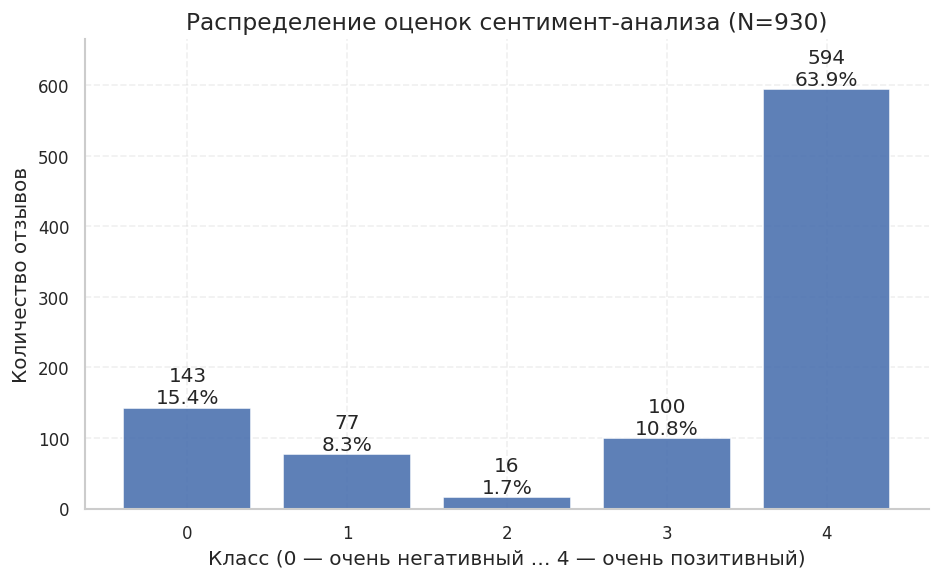

,class,count,percent,cum_percent
0,0,143,15.4000,15.4000
1,1,77,8.3000,23.7000
2,2,16,1.7000,25.4000
3,3,100,10.8000,36.2000
4,4,594,63.9000,100.1000


In [18]:
# Задание 2.4 — распределение оценок сентимента (0..4), без повторного объявления стиля

# выбираем источник данных (без булевой проверки DataFrame)
target_df = globals().get("df_hosp_msk", None)
if target_df is None:
    target_df = globals().get("df", None)
if target_df is None:
    raise NameError("Не найден ни 'df_hosp_msk', ни 'df'. Сначала выполните предыдущие задания.")
if "sentiment" not in target_df.columns:
    raise KeyError("В таблице нет столбца 'sentiment'. Сначала выполните задание 2.3.")

# подготовка данных
s = pd.to_numeric(target_df["sentiment"], errors="coerce").dropna().astype(int)
if s.empty:
    raise ValueError("Нет валидных значений 'sentiment' для построения графика.")

classes = np.arange(5)  # 0..4
counts = np.bincount(s.values, minlength=5)[:5]
total = int(counts.sum())
percents = counts / max(total, 1) * 100

# стиль — используем ранее объявленный, если он есть
try:
    use_plot_style()
except NameError:
    pass
try:
    finalize_axes
except NameError:
    def finalize_axes(ax, title="", xlabel="", ylabel=""):
        ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)

# построение графика
fig, ax = plt.subplots()
ax.bar(classes, counts, alpha=0.9)
ax.set_xticks(classes)

# запас сверху, чтобы не обрезало подписи
ymax = (counts.max() * 1.12) if counts.size and counts.max() > 0 else 1
ax.set_ylim(0, ymax)

finalize_axes(
    ax,
    title=f"Распределение оценок сентимент-анализа (N={total})",
    xlabel="Класс (0 — очень негативный … 4 — очень позитивный)",
    ylabel="Количество отзывов",
)

# подписи на столбцах
for x, v, p in zip(classes, counts, percents):
    ax.text(x, v, f"{v}\n{p:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# компактная таблица распределения (с кумулятивной долей)
dist_df = pd.DataFrame({
    "class": classes,
    "count": counts,
    "percent": np.round(percents, 1)
})
dist_df["cum_percent"] = dist_df["percent"].cumsum().round(1)

try:
    from IPython.display import display
    display(dist_df)
except Exception:
    print(dist_df.to_string(index=False))


In [19]:
# Задание 3.1 — фильтрация негативных/нейтральных отзывов: sentiment ∈ {0,1,2}

def filter_sentiment_range(
    df_in: pd.DataFrame,
    sentiment_col: str = "sentiment",
    lower: int = 0,
    upper: int = 2
) -> pd.DataFrame:
    """
    Отфильтровать строки, у которых значение столбца `sentiment` попадает в [lower, upper].

    Parameters
    ----------
    df_in : pd.DataFrame
        Входной датафрейм.
    sentiment_col : str
        Имя столбца с метками сентимента (0..4).
    lower : int
        Нижняя граница включительно.
    upper : int
        Верхняя граница включительно.

    Returns
    -------
    pd.DataFrame
        Копия отфильтрованного датафрейма; столбец sentiment приведён к Int64.
    """
    if sentiment_col not in df_in.columns:
        raise KeyError(f"В таблице нет столбца '{sentiment_col}'. Сначала выполните задание 2.3.")
    if not (0 <= lower <= upper <= 4):
        raise ValueError("Границы должны удовлетворять 0 ≤ lower ≤ upper ≤ 4.")

    s = pd.to_numeric(df_in[sentiment_col], errors="coerce")
    mask = s.between(lower, upper, inclusive="both")
    out = df_in.loc[mask].copy()
    out[sentiment_col] = s.loc[mask].astype("Int64")
    return out.reset_index(drop=True)


# Безопасно выбираем источник данных: сначала df_hosp_msk (если есть и не пустой), иначе df
target_df = globals().get("df_hosp_msk", None)
if not isinstance(target_df, pd.DataFrame) or target_df.empty:
    target_df = globals().get("df", None)
if not isinstance(target_df, pd.DataFrame):
    raise NameError("Не найден ни 'df_hosp_msk', ни 'df'. Выполните предыдущие задания.")

# Фильтрация 0..2
df_neg = filter_sentiment_range(target_df, sentiment_col="sentiment", lower=0, upper=2)

# Короткая сводка
total = len(target_df)
neg_n = len(df_neg)
print(f"✅ Отобрано {neg_n} из {total} записей (sentiment 0..2). Доля: {neg_n/total:.1%}")

# Распределение внутри среза (0,1,2)
vc = pd.to_numeric(df_neg["sentiment"], errors="coerce").value_counts().sort_index()
vc = vc.reindex([0,1,2], fill_value=0)
share = (vc / max(neg_n, 1) * 100).round(1)
dist_table = pd.DataFrame({"class": vc.index, "count": vc.values, "percent": share.values})
try:
    from IPython.display import display
    display(dist_table)
except Exception:
    print(dist_table.to_string(index=False))

# Превью данных
display(df_neg.head(10))
# Задание 3 — фильтрация негативных/нейтральных отзывов: sentiment ∈ {0,1,2}

def filter_sentiment_range(
    df_in: pd.DataFrame,
    sentiment_col: str = "sentiment",
    lower: int = 0,
    upper: int = 2
) -> pd.DataFrame:
    """
    Отфильтровать строки, у которых значение столбца `sentiment` попадает в [lower, upper].

    Parameters
    ----------
    df_in : pd.DataFrame
        Входной датафрейм.
    sentiment_col : str
        Имя столбца с метками сентимента (0..4).
    lower : int
        Нижняя граница включительно.
    upper : int
        Верхняя граница включительно.

    Returns
    -------
    pd.DataFrame
        Копия отфильтрованного датафрейма; столбец sentiment приведён к Int64.
    """
    if sentiment_col not in df_in.columns:
        raise KeyError(f"В таблице нет столбца '{sentiment_col}'. Сначала выполните задание 2.3.")
    if not (0 <= lower <= upper <= 4):
        raise ValueError("Границы должны удовлетворять 0 ≤ lower ≤ upper ≤ 4.")

    s = pd.to_numeric(df_in[sentiment_col], errors="coerce")
    mask = s.between(lower, upper, inclusive="both")
    out = df_in.loc[mask].copy()
    out[sentiment_col] = s.loc[mask].astype("Int64")
    return out.reset_index(drop=True)


# Безопасно выбираем источник данных: сначала df_hosp_msk (если есть и не пустой), иначе df
target_df = globals().get("df_hosp_msk", None)
if not isinstance(target_df, pd.DataFrame) or target_df.empty:
    target_df = globals().get("df", None)
if not isinstance(target_df, pd.DataFrame):
    raise NameError("Не найден ни 'df_hosp_msk', ни 'df'. Выполните предыдущие задания.")

# Фильтрация 0..2
df_neg = filter_sentiment_range(target_df, sentiment_col="sentiment", lower=0, upper=2)

# Короткая сводка
total = len(target_df)
neg_n = len(df_neg)
print(f"✅ Отобрано {neg_n} из {total} записей (sentiment 0..2). Доля: {neg_n/total:.1%}")

# Распределение внутри среза (0,1,2)
vc = pd.to_numeric(df_neg["sentiment"], errors="coerce").value_counts().sort_index()
vc = vc.reindex([0,1,2], fill_value=0)
share = (vc / max(neg_n, 1) * 100).round(1)
dist_table = pd.DataFrame({"class": vc.index, "count": vc.values, "percent": share.values})
try:
    from IPython.display import display
    display(dist_table)
except Exception:
    print(dist_table.to_string(index=False))

# Превью данных
display(df_neg.head(10))


✅ Отобрано 236 из 930 записей (sentiment 0..2). Доля: 25.4%


,class,count,percent
0,0,143,60.6000
1,1,77,32.6000
2,2,16,6.8000


,address,rubrics,name_ru,rating,text,sentiment
0,"Москва, улица Матросская Тишина, 14",Детская поликлиника;Детская больница,"Детская поликлиника № 52, филиал № 1",5.0000,Оборудование и здание после ремонта шикарные! ...,1
1,"Москва, Велозаводская улица, 1/1",Больница для взрослых,"Городская Клиническая больница № 13, ортопедич...",1.0000,"Сегодня привозила дедушку, (не может кушать и ...",0
2,"Москва, Пехотная улица, 3",Больница для взрослых;Родильный дом,ГБУЗ Городская клиническая больница № 52,5.0000,Стационар очень изменился в лучшею сторону с 2...,1
3,"Москва, Пехотная улица, 3",Больница для взрослых;Родильный дом,ГБУЗ Городская клиническая больница № 52,3.0000,Был там к сожалению по печальному событию. Оце...,1
4,"Москва, улица Плещеева, 28",Женская консультация;Больница для взрослых,Женская консультация № 2 ГКБ им. А. К. Ерамиша...,3.0000,"3 /5 \nАкушерки, например, хорошие, добрые. От...",2
5,"Москва, 4-й Добрынинский переулок, 1/9с21",Детская больница,ГБУЗ Морозовская детская городская клиническая...,1.0000,"Больницу не посещала, попросту не могу попасть...",0
6,"Москва, 4-й Добрынинский переулок, 1/9с21",Детская больница,ГБУЗ Морозовская детская городская клиническая...,1.0000,"Во что превратилась Морозовская больница, это ...",0
7,"Москва, 4-й Добрынинский переулок, 1/9с21",Детская больница,ГБУЗ Морозовская детская городская клиническая...,5.0000,Тысячи проходов на здание но пропускает только...,1
8,"Москва, 4-й Добрынинский переулок, 1/9с21",Детская больница,ГБУЗ Морозовская детская городская клиническая...,1.0000,Скорая отправила с ребёнком в больницу. В виду...,0
9,"Москва, 4-й Добрынинский переулок, 1/9с21",Детская больница,ГБУЗ Морозовская детская городская клиническая...,1.0000,"не скажу за всю больницу целиком, но 8 гематол...",1


✅ Отобрано 236 из 930 записей (sentiment 0..2). Доля: 25.4%


,class,count,percent
0,0,143,60.6000
1,1,77,32.6000
2,2,16,6.8000


,address,rubrics,name_ru,rating,text,sentiment
0,"Москва, улица Матросская Тишина, 14",Детская поликлиника;Детская больница,"Детская поликлиника № 52, филиал № 1",5.0000,Оборудование и здание после ремонта шикарные! ...,1
1,"Москва, Велозаводская улица, 1/1",Больница для взрослых,"Городская Клиническая больница № 13, ортопедич...",1.0000,"Сегодня привозила дедушку, (не может кушать и ...",0
2,"Москва, Пехотная улица, 3",Больница для взрослых;Родильный дом,ГБУЗ Городская клиническая больница № 52,5.0000,Стационар очень изменился в лучшею сторону с 2...,1
3,"Москва, Пехотная улица, 3",Больница для взрослых;Родильный дом,ГБУЗ Городская клиническая больница № 52,3.0000,Был там к сожалению по печальному событию. Оце...,1
4,"Москва, улица Плещеева, 28",Женская консультация;Больница для взрослых,Женская консультация № 2 ГКБ им. А. К. Ерамиша...,3.0000,"3 /5 \nАкушерки, например, хорошие, добрые. От...",2
5,"Москва, 4-й Добрынинский переулок, 1/9с21",Детская больница,ГБУЗ Морозовская детская городская клиническая...,1.0000,"Больницу не посещала, попросту не могу попасть...",0
6,"Москва, 4-й Добрынинский переулок, 1/9с21",Детская больница,ГБУЗ Морозовская детская городская клиническая...,1.0000,"Во что превратилась Морозовская больница, это ...",0
7,"Москва, 4-й Добрынинский переулок, 1/9с21",Детская больница,ГБУЗ Морозовская детская городская клиническая...,5.0000,Тысячи проходов на здание но пропускает только...,1
8,"Москва, 4-й Добрынинский переулок, 1/9с21",Детская больница,ГБУЗ Морозовская детская городская клиническая...,1.0000,Скорая отправила с ребёнком в больницу. В виду...,0
9,"Москва, 4-й Добрынинский переулок, 1/9с21",Детская больница,ГБУЗ Морозовская детская городская клиническая...,1.0000,"не скажу за всю больницу целиком, но 8 гематол...",1


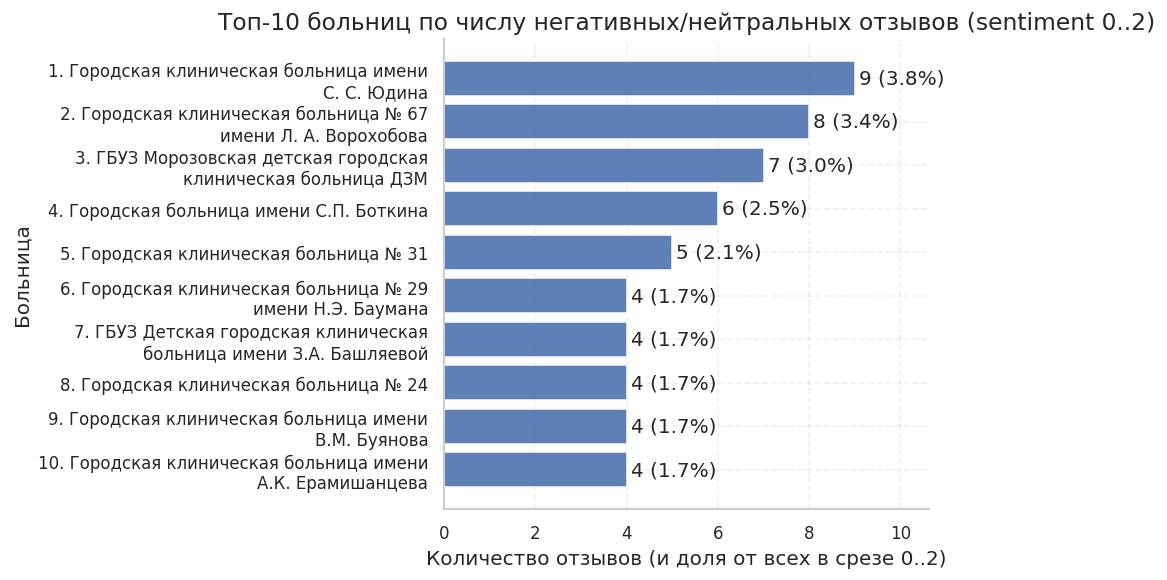

,№,hospital,count,share_%,cum_share_%
0,1,Городская клиническая больница имени С. С. Юдина,9,3.8000,3.8000
1,2,Городская клиническая больница № 67 имени Л. А...,8,3.4000,7.2000
2,3,ГБУЗ Морозовская детская городская клиническая...,7,3.0000,10.2000
3,4,Городская больница имени С.П. Боткина,6,2.5000,12.7000
4,5,Городская клиническая больница № 31,5,2.1000,14.8000
5,6,Городская клиническая больница № 29 имени Н.Э....,4,1.7000,16.5000
6,7,ГБУЗ Детская городская клиническая больница им...,4,1.7000,18.2000
7,8,Городская клиническая больница № 24,4,1.7000,19.9000
8,9,Городская клиническая больница имени В.М. Буянова,4,1.7000,21.6000
9,10,Городская клиническая больница имени А.К. Ерам...,4,1.7000,23.3000


In [20]:
# Задание 3.2 — Топ-10 больниц по числу негативных/нейтральных отзывов (sentiment 0..2)
# Требуется: столбцы name_ru, sentiment; (желательно text, но не обязательно)

def _normalize_series(col: pd.Series | pd.DataFrame) -> pd.Series:
    """
    Гарантировать Series и нормализовать строки:
    unicode-NFKC, casefold, замена неразрывных пробелов, схлопывание пробелов, trim.
    Если пришёл DataFrame (из-за дублей имён) — берём первый столбец.
    """
    s = col.iloc[:, 0] if isinstance(col, pd.DataFrame) else col
    s = s.astype(str)

    # локальный импорт stdlib, чтобы не засорять глобальные импорты
    import unicodedata as _ud

    def _norm_one(x: str) -> str:
        x = _ud.normalize("NFKC", x)
        x = x.replace("\u00A0", " ")     # неразрывный пробел -> обычный
        x = x.casefold()
        x = " ".join(x.split())          # схлопывание любых пробелов
        return x.strip()

    return s.map(_norm_one)


def ensure_df_neg(df_in: pd.DataFrame, sentiment_col: str = "sentiment") -> pd.DataFrame:
    """
    Вернуть df с отзывами, у которых sentiment ∈ {0,1,2}.
    """
    if sentiment_col not in df_in.columns:
        raise KeyError("Нет столбца 'sentiment'. Сначала выполните задание 2.3 (классы 0..4).")
    s = pd.to_numeric(df_in[sentiment_col], errors="coerce")
    out = df_in.loc[s.isin([0, 1, 2])].copy()
    out[sentiment_col] = s.loc[out.index].astype("Int64")
    if out.empty:
        raise ValueError("Нет строк с sentiment в {0,1,2}. Проверьте предыдущие шаги.")
    return out.reset_index(drop=True)


def top_hospitals_in_negative_by_name_ru(
    df_in: pd.DataFrame,
    name_col: str = "name_ru",
    top_k: int = 10
) -> pd.DataFrame:
    """
    Подсчитать количество негативных/нейтральных отзывов по name_ru.

    Возвращает DataFrame с колонками:
      - hospital : «красивое» исходное название (самый частый вариант)
      - count    : число отзывов (sentiment 0..2)
      - share_%  : доля от всех (по срезу sentiment 0..2)
      - cum_share_% : кумулятивная доля в отсортированном топе
    """
    if name_col not in df_in.columns:
        raise KeyError("Нет столбца 'name_ru'. Покажите df.columns — подстрою код.")
    df_local = df_in.copy()

    # нормализуем имя и отсекаем пустые/служебные значения
    df_local["_name_norm"] = _normalize_series(df_local[[name_col]])
    mask_valid = df_local["_name_norm"].ne("") & ~df_local["_name_norm"].isin(["nan", "none"])
    df_local = df_local.loc[mask_valid].copy()
    if df_local.empty:
        raise ValueError("После нормализации не осталось валидных имён больниц.")

    # счётчик по нормализованному имени
    cnt = (
        df_local.groupby("_name_norm", dropna=False)
        .size()
        .reset_index(name="count")
    )

    # «красивое» имя — самый частый исходный вариант в группе
    name_mode = (
        df_local.groupby("_name_norm")[name_col]
        .agg(lambda s: s.value_counts().idxmax())
        .reset_index(name="hospital")
    )

    agg = cnt.merge(name_mode, on="_name_norm", how="left")
    agg = agg[["hospital", "count"]]

    total_neg = int(agg["count"].sum()) or 1
    agg["share_%"] = agg["count"] / total_neg * 100

    # топ-k и кумулятивная доля
    top = (
        agg.sort_values("count", ascending=False)
           .head(top_k)
           .reset_index(drop=True)
    )
    top["cum_share_%"] = top["share_%"].cumsum()
    return top


# ---------- ДАННЫЕ ----------
# Берём df_neg, если уже есть; иначе строим из df_hosp_msk (или df)
if "df_neg" in globals() and isinstance(df_neg, pd.DataFrame):
    base = df_neg
else:
    base_candidate = globals().get("df_hosp_msk", None)
    if not isinstance(base_candidate, pd.DataFrame) or base_candidate.empty:
        base_candidate = globals().get("df", None)
    if base_candidate is None or not isinstance(base_candidate, pd.DataFrame):
        raise NameError("Нет df_hosp_msk/df. Выполните задания 1.3–1.4 и 2.3.")
    base = ensure_df_neg(base_candidate, "sentiment")

# ---------- ТОП-10 ----------
top10_neg = top_hospitals_in_negative_by_name_ru(base, name_col="name_ru", top_k=10)

# Добавляем колонку ранга (1..10) и округляем проценты
top10_neg_ranked = top10_neg.copy()
top10_neg_ranked.insert(0, "№", np.arange(1, len(top10_neg_ranked) + 1, dtype=int))
top10_neg_ranked["share_%"] = top10_neg_ranked["share_%"].round(1)
top10_neg_ranked["cum_share_%"] = top10_neg_ranked["cum_share_%"].round(1)

# ---------- ГРАФИК ----------
# стиль — как раньше, с фолбэком
try:
    use_plot_style()
except NameError:
    plt.rcParams.update({
        "figure.figsize": (10, 6),
        "axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.3,
        "axes.titlesize": 14, "axes.labelsize": 12, "xtick.labelsize": 10, "ytick.labelsize": 10,
        "figure.dpi": 120,
    })
try:
    finalize_axes
except NameError:
    def finalize_axes(ax, title="", xlabel="", ylabel=""):
        ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)

labels = [f"{i}. {name}" for i, name in enumerate(top10_neg_ranked["hospital"].astype(str).values, start=1)]
values = top10_neg_ranked["count"].astype(int).values
shares = top10_neg_ranked["share_%"].values

# перенос длинных подписей без новых импортов
def _wrap_label(text: str, width: int = 40) -> str:
    words, lines, cur = text.split(), [], ""
    for w in words:
        if len(cur) + (1 if cur else 0) + len(w) <= width:
            cur = f"{cur} {w}".strip()
        else:
            if cur: lines.append(cur)
            cur = w
    if cur: lines.append(cur)
    return "\n".join(lines)

wrapped_labels = [_wrap_label(s) for s in labels]

fig, ax = plt.subplots()
y_pos = range(len(values))
bars = ax.barh(list(y_pos), values, alpha=0.9)

ax.set_yticks(list(y_pos))
ax.set_yticklabels(wrapped_labels)
ax.invert_yaxis()  # самый частый — сверху

# подписи: "число (доля %)"
x_pad = (max(values) * 0.01) if values.size else 0.5
for i, (bar, v, p) in enumerate(zip(bars, values, shares)):
    v_str = f"{v:,.0f}".replace(",", " ")
    ax.text(bar.get_width() + x_pad, i, f"{v_str} ({p:.1f}%)", va="center")

# небольшой запас справа
ax.set_xlim(0, max(values) * 1.18 if values.size else 1)

finalize_axes(
    ax,
    title="Топ-10 больниц по числу негативных/нейтральных отзывов (sentiment 0..2)",
    xlabel="Количество отзывов (и доля от всех в срезе 0..2)",
    ylabel="Больница",
)
plt.tight_layout()
plt.show()

# ---------- ТАБЛИЦА ----------
display(top10_neg_ranked)

# (опционально) сохранить
# top10_neg_ranked.to_csv("/content/top10_negative_reviews_by_hospital.csv", index=False, encoding="utf-8-sig")


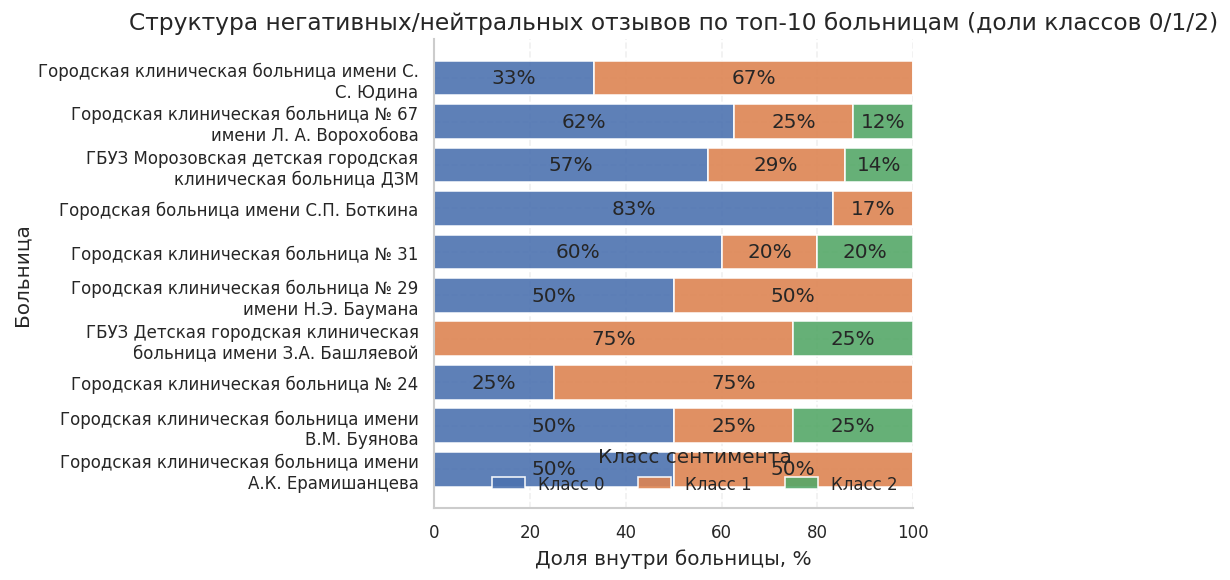

In [21]:
# Задание 3.2 — вторая визуализация: stacked bar долей классов 0/1/2 по топ-10 больницам

# --- подготовка данных для структуры классов 0/1/2 ---
if "top10_neg_ranked" not in globals():
    raise NameError("Не найден top10_neg_ranked. Сначала выполните шаг 3.2 (топ-10).")
if "base" not in globals():
    # резерв: берём df_neg или строим из df_hosp_msk/df
    if "df_neg" in globals() and isinstance(df_neg, pd.DataFrame):
        base = df_neg
    else:
        base_candidate = globals().get("df_hosp_msk", None)
        if not isinstance(base_candidate, pd.DataFrame) or base_candidate.empty:
            base_candidate = globals().get("df", None)
        if base_candidate is None or not isinstance(base_candidate, pd.DataFrame):
            raise NameError("Нет df_hosp_msk/df. Выполните задания 1.3–1.4 и 2.3.")
        # используем ensure_df_neg из предыдущей ячейки
        base = ensure_df_neg(base_candidate, "sentiment")

# защита: простая версия нормализации, если функция не была определена ранее
try:
    _normalize_series
except NameError:
    def _normalize_series(col):
        s = col.iloc[:, 0] if isinstance(col, pd.DataFrame) else col
        return (s.astype(str).str.lower().str.replace(r"\s+", " ", regex=True).str.strip())

df_local = base.copy()
df_local["_name_norm"] = _normalize_series(df_local[["name_ru"]])
df_local["sentiment"] = pd.to_numeric(df_local["sentiment"], errors="coerce").astype("Int64")
df_local = df_local[df_local["sentiment"].isin([0, 1, 2])]

# маппинг _name_norm -> «красивое» имя (самый частый вариант), чтобы совпадало с top10_neg_ranked
name_mode = (
    df_local.groupby("_name_norm")["name_ru"]
    .agg(lambda s: s.value_counts().idxmax())
    .rename("hospital")
    .reset_index()
)
# порядок больниц как в топ-10
top_labels = top10_neg_ranked["hospital"].astype(str).tolist()

# сопоставим «красивое» имя -> нормализованное
display2norm = name_mode.set_index("hospital")["_name_norm"].to_dict()
norm_order = []
for h in top_labels:
    nk = display2norm.get(h)
    if nk is None:
        # резерв: нормализуем сам текст заголовка
        nk = _normalize_series(pd.Series([h])).iloc[0]
    norm_order.append(nk)

# подсчёт распределения классов (0/1/2) по выбранным больницам
ct = (
    df_local[df_local["_name_norm"].isin(norm_order)]
    .groupby(["_name_norm", "sentiment"])
    .size()
    .unstack(fill_value=0)
)

# гарантируем наличие столбцов 0,1,2 и порядок больниц
for c in [0, 1, 2]:
    if c not in ct.columns:
        ct[c] = 0
ct = ct[[0, 1, 2]].reindex(norm_order, fill_value=0)

# проценты внутри каждой больницы (строковая нормализация)
row_sums = ct.sum(axis=1).replace(0, np.nan)
pct = (ct.div(row_sums, axis=0) * 100).fillna(0.0)

# --- построение stacked bar ---
try:
    use_plot_style()
except NameError:
    pass
try:
    finalize_axes
except NameError:
    def finalize_axes(ax, title="", xlabel="", ylabel=""):
        ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)

labels = top_labels  # как в таблице top10_neg_ranked
y = np.arange(len(labels))
w0 = pct[0].to_numpy()
w1 = pct[1].to_numpy()
w2 = pct[2].to_numpy()

fig, ax = plt.subplots()

bars0 = ax.barh(y, w0, label="Класс 0", alpha=0.9)
bars1 = ax.barh(y, w1, left=w0, label="Класс 1", alpha=0.9)
bars2 = ax.barh(y, w2, left=w0 + w1, label="Класс 2", alpha=0.9)

# перенос длинных подписей (локальная мини-функция)
def _wrap(text: str, width: int = 40) -> str:
    words, lines, cur = str(text).split(), [], ""
    for w in words:
        if len(cur) + (1 if cur else 0) + len(w) <= width:
            cur = f"{cur} {w}".strip()
        else:
            if cur: lines.append(cur)
            cur = w
    if cur: lines.append(cur)
    return "\n".join(lines)

ax.set_yticks(y)
ax.set_yticklabels([_wrap(t) for t in labels])
ax.invert_yaxis()
ax.set_xlim(0, 100)

# подписи процентов внутри сегментов (показываем, если сегмент >= 6%)
def _annotate_segment(left_arr, width_arr):
    for i, (lft, wd) in enumerate(zip(left_arr, width_arr)):
        if wd >= 6:
            ax.text(lft + wd / 2, i, f"{wd:.0f}%", ha="center", va="center")

_annotate_segment(np.zeros_like(w0), w0)
_annotate_segment(w0, w1)
_annotate_segment(w0 + w1, w2)

ax.legend(title="Класс сентимента", ncol=3, loc="lower right", frameon=False)
finalize_axes(
    ax,
    title="Структура негативных/нейтральных отзывов по топ-10 больницам (доли классов 0/1/2)",
    xlabel="Доля внутри больницы, %",
    ylabel="Больница",
)
plt.tight_layout()
plt.show()


In [22]:
# Задание 3.3 — отбор негативных комментариев больницы №1 в топе

def _detect_name_column(df: pd.DataFrame) -> str:
    """
    Найти столбец с названием больницы по типичным именам.
    """
    preferred = ("name_ru", "name", "title_ru", "title", "org_name", "place_name", "hospital", "clinic")
    for c in preferred:
        if c in df.columns:
            return c
    # фолбэк — первый object-столбец
    for c in df.columns:
        if df[c].dtype == "object":
            return c
    raise KeyError("Не найден столбец с названием больницы (например: 'name_ru', 'name', 'title').")


def _detect_text_column(df: pd.DataFrame) -> str:
    """
    Найти столбец с текстом отзыва.
    """
    candidates = ("review_text", "text", "comment", "review", "body", "content", "message", "description", "text_ru")
    for c in candidates:
        if c in df.columns:
            return c
    # фолбэк — первый object-столбец, не совпадающий с name/address
    name_c = _detect_name_column(df)
    for c in df.columns:
        if df[c].dtype == "object" and c not in (name_c, "address"):
            return c
    raise KeyError("Не найден столбец с текстом отзывов (например: 'text', 'review_text').")


def _norm(s: object) -> str:
    """
    Нормализация строки для сравнения: NFKC + casefold + замена NBSP + схлопывание пробелов.
    """
    import unicodedata as _ud
    x = "" if s is None else str(s)
    x = _ud.normalize("NFKC", x).replace("\u00A0", " ").casefold().strip()
    return " ".join(x.split())


def _ensure_df_neg(source_df: pd.DataFrame, sentiment_col: str = "sentiment") -> pd.DataFrame:
    """
    Готовит df_neg (sentiment ∈ {0,1,2}) из исходного датафрейма.
    """
    if sentiment_col not in source_df.columns:
        raise KeyError(f"Нет столбца '{sentiment_col}'. Сначала выполните задание 2.3.")
    s = pd.to_numeric(source_df[sentiment_col], errors="coerce")
    out = source_df.loc[s.isin([0, 1, 2])].copy()
    out[sentiment_col] = s.loc[out.index].astype("Int64")
    return out.reset_index(drop=True)


def top_hospitals_in_negative(
    df_in: pd.DataFrame,
    sentiment_col: str = "sentiment",
    top_k: int = 10
) -> pd.DataFrame:
    """
    Подсчитать частоту упоминаний больниц в негативных/нейтральных отзывах (0..2).
    Возвращает таблицу с колонками ['hospital', 'address', 'count'] (если address существует),
    иначе ['hospital', 'count'].
    """
    name_col = _detect_name_column(df_in)
    has_addr = "address" in df_in.columns

    s = pd.to_numeric(df_in[sentiment_col], errors="coerce")
    cols = [name_col] + (["address"] if has_addr else [])
    tmp = df_in.loc[s.isin([0, 1, 2]), cols].copy()
    if tmp.empty:
        raise ValueError("Нет строк с sentiment ∈ {0,1,2}.")

    tmp["_name_norm"] = tmp[name_col].map(_norm)
    if has_addr:
        tmp["_addr_norm"] = tmp["address"].map(_norm)

    # группировка по нормализованным ключам
    by = ["_name_norm", "_addr_norm"] if has_addr else ["_name_norm"]
    agg = (
        tmp.groupby(by, as_index=False)
           .agg(count=(name_col, "size"))
    )

    # красивое имя: самый частый исходный вариант
    name_mode = (
        tmp.groupby(by)[name_col]
           .agg(lambda s: s.value_counts().idxmax())
           .rename("hospital")
           .reset_index()
    )
    merged = agg.merge(name_mode, on=by, how="left")

    if has_addr:
        # адрес: наиболее частый в группе
        addr_mode = (
            tmp.groupby(by)["address"]
               .agg(lambda s: s.value_counts().idxmax())
               .rename("address")
               .reset_index()
        )
        merged = merged.merge(addr_mode, on=by, how="left")

        top = merged.sort_values("count", ascending=False).head(top_k)
        return top[["hospital", "address", "count"]].reset_index(drop=True)
    else:
        top = merged.sort_values("count", ascending=False).head(top_k)
        return top[["hospital", "count"]].reset_index(drop=True)


# --- источники данных ---
base_df = globals().get("df_hosp_msk", None)
if not isinstance(base_df, pd.DataFrame):
    base_df = globals().get("df", None)
if not isinstance(base_df, pd.DataFrame):
    raise NameError("Не найден ни 'df_hosp_msk', ни 'df'.")

df_neg = globals().get("df_neg")
if not isinstance(df_neg, pd.DataFrame):
    df_neg = _ensure_df_neg(base_df, "sentiment")

# --- получаем топ-1 больницу по числу негативных отзывов ---
if "top10_neg" in globals() and isinstance(top10_neg, pd.DataFrame) and not top10_neg.empty:
    top_row = top10_neg.iloc[0]
else:
    top10_neg = top_hospitals_in_negative(df_neg, sentiment_col="sentiment", top_k=10)
    top_row = top10_neg.iloc[0]

target_hosp = str(top_row["hospital"])
target_addr = str(top_row["address"]) if "address" in top10_neg.columns else None

name_col = _detect_name_column(df_neg)
has_addr = "address" in df_neg.columns

# --- фильтрация по названию (и адресу, если есть) с нормализацией ---
name_norm = _norm(target_hosp)
mask_name = df_neg[name_col].astype(str).map(_norm).eq(name_norm)

if has_addr and target_addr and target_addr.lower() != "nan" and target_addr.strip() != "":
    addr_norm = _norm(target_addr)
    mask_addr = df_neg["address"].astype(str).map(_norm).eq(addr_norm)
    mask = mask_name & mask_addr
else:
    mask = mask_name

df_top_hosp_neg = df_neg.loc[mask].copy().reset_index(drop=True)

# фолбэк: если по имени+адресу ничего не нашли — берём только по имени
if df_top_hosp_neg.empty and (has_addr and target_addr):
    print("⚠️ По сочетанию (имя+адрес) ничего не найдено — использую фильтр только по имени.")
    df_top_hosp_neg = df_neg.loc[mask_name].copy().reset_index(drop=True)

# --- быстрая сводка и превью ---
try:
    from IPython.display import display  # на случай, если не импортировано
except Exception:
    display = print  # грубый фолбэк

text_col = _detect_text_column(df_top_hosp_neg)
counts_by_class = df_top_hosp_neg["sentiment"].value_counts().sort_index()

print(f"Больница №1 по негативным отзывам: {target_hosp}")
if has_addr and target_addr and target_addr.strip():
    print(f"Адрес (из топа): {target_addr}")
print(f"Всего негативных/нейтральных отзывов: {len(df_top_hosp_neg)}")
print("Распределение классов (0=оч.негативный … 2=нейтральный):")
display(counts_by_class)

# Покажем первые тексты
preview_cols = [c for c in (name_col, "address", "sentiment", text_col) if c in df_top_hosp_neg.columns]
display(df_top_hosp_neg[preview_cols].head(15))

# df_top_hosp_neg — готов для LDA / дальнейшего анализа
# при необходимости можно сохранить:
# df_top_hosp_neg.to_parquet("/content/df_top_hospital_negative.parquet", index=False)


Больница №1 по негативным отзывам: Городская клиническая больница имени С. С. Юдина
Всего негативных/нейтральных отзывов: 9
Распределение классов (0=оч.негативный … 2=нейтральный):


,count
sentiment,
0,3
1,6


,name_ru,address,sentiment,text
0,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,Специалисты работают шикарные. \nНо в плане ор...
1,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,"Была здесь несколько раз. Рожала в роддоме, по..."
2,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,"К самой больнице претензий нет, лечат, обращаю..."
3,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",0,"Мама, лежала месяц у них в реаниации, за этот ..."
4,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",0,Врагу не пожелаешь попасть в приемный покой в ...
5,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,Больница после ремонта. \nНе понятная ситуация...
6,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,Оперировалась в 4 травме у Мазалова АВ очень г...
7,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",0,Хочу выразить благодарность персоналу 4 ХО.Все...
8,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,Дважды пришлось прокатиться здесь на лифте. Пе...


In [23]:
# Задание 3.4 — zero-shot классификация негативных отзывов на 4 категории
# Используем df_top_hosp_neg из 3.3 (если нет — возьмём df_neg).
# Результат: новые колонки 'topic' (метка) и 'topic_score' (доверие 0..1).

LABELS = [
    "Запись в больницу",
    "Квалификация врачей",
    "Качество лечения",
    "Ремонт и оборудование",
]


def _detect_text_column(df: pd.DataFrame) -> str:
    """
    Найти столбец с текстом отзыва.
    """
    for c in ("review_text", "text", "comment", "review", "body", "content", "message", "description"):
        if c in df.columns:
            return c
    # fallback — первый object-столбец, не совпадающий с name/address
    for c in df.columns:
        if df[c].dtype == "object" and c not in ("name", "title", "org_name", "place_name", "address"):
            return c
    raise KeyError("Не найден столбец с текстом отзывов (например: 'text', 'review_text').")


def _clean_labels(labels: list[str]) -> list[str]:
    """Убрать пустые и дубли, обрезать пробелы, сохранить порядок."""
    seen, out = set(), []
    for lbl in (str(x).strip() for x in labels):
        if lbl and lbl not in seen:
            seen.add(lbl)
            out.append(lbl)
    if not out:
        raise ValueError("Список меток пуст после очистки.")
    return out


def get_zero_shot_classifier(
    model_name: str = "joeddav/xlm-roberta-large-xnli",
    device_pref: int = 0,
    fallback_model: str = "facebook/bart-large-mnli"  # англ. fallback на всякий случай
):
    """
    Инициализировать zero-shot классификатор (предпочтительно мультиязычный/XNLI).
    """
    dev = 0 if (device_pref == 0 and torch.cuda.is_available()) else -1
    try:
        clf = pipeline(
            "zero-shot-classification",
            model=model_name,
            device=dev
        )
        # пробный прогон
        _ = clf("test", candidate_labels=["A", "B"], hypothesis_template="This text is about {}.",
                truncation=True, padding=True, max_length=256)
        print(f"Zero-shot модель: {model_name} (device={'GPU' if dev == 0 else 'CPU'})")
        return clf
    except Exception as e:
        print(f"⚠️ '{model_name}' не подошла ({type(e).__name__}). Переключаюсь на {fallback_model}.")
        clf = pipeline(
            "zero-shot-classification",
            model=fallback_model,
            device=dev
        )
        print(f"Zero-shot модель: {fallback_model} (device={'GPU' if dev == 0 else 'CPU'})")
        return clf


def split_by_newline(text: object) -> list[str]:
    """
    Разбить отзыв на сегменты по '\\n', удалить пустые части.
    """
    if not isinstance(text, str):
        return []
    parts = [p.strip() for p in text.split("\n")]
    # отбрасываем очень короткие куски (шум)
    return [p for p in parts if p and len(p) >= 4]


def classify_reviews_by_segments(
    df_in: pd.DataFrame,
    text_col: str,
    clf,
    candidate_labels: list[str],
    hypothesis_template: str = "This text is about {}.",
    batch_size: int | None = None,
) -> pd.DataFrame:
    """
    Для каждой строки: разбить текст по '\\n', прогнать сегменты через zero-shot,
    усреднить скоры по меткам и выбрать лучшую.

    Возвращает копию df_in с колонками:
      - 'topic'        (строка из candidate_labels)
      - 'topic_score'  (float, 0..1)
    """
    candidate_labels = _clean_labels(candidate_labels)

    # Автовыбор батча
    if batch_size is None:
        try:
            on_gpu = (getattr(clf, "device", None) is not None) and (clf.device.type == "cuda")  # type: ignore[attr-defined]
        except Exception:
            on_gpu = False
        batch_size = 16 if on_gpu else 4

    # Собираем все сегменты и маппинг строка->сегменты
    row_indices: list[int] = []
    segments: list[str] = []
    for i, txt in df_in[text_col].items():
        segs = split_by_newline(txt)
        if not segs:
            continue
        segments.extend(segs)
        row_indices.extend([i] * len(segs))

    if not segments:
        out = df_in.copy()
        out["topic"] = pd.NA
        out["topic_score"] = np.nan
        return out

    # Инференс батчами
    preds_all = []
    for start in range(0, len(segments), batch_size):
        batch = segments[start:start + batch_size]
        preds = clf(
            sequences=batch,
            candidate_labels=candidate_labels,
            multi_label=False,
            hypothesis_template=hypothesis_template,
            truncation=True,
            padding=True,
            max_length=256
        )
        if isinstance(preds, dict):
            preds = [preds]
        preds_all.extend(preds)

    # Агрегируем скоры по строкам
    label_set = list(candidate_labels)
    score_sum: dict[int, np.ndarray] = {}
    count_segs: dict[int, int] = {}

    for (row_idx, pred) in zip(row_indices, preds_all):
        l2s = {lbl: scr for lbl, scr in zip(pred["labels"], pred["scores"])}
        vec = np.array([float(l2s.get(lbl, 0.0)) for lbl in label_set], dtype=float)
        if row_idx not in score_sum:
            score_sum[row_idx] = vec
            count_segs[row_idx] = 1
        else:
            score_sum[row_idx] += vec
            count_segs[row_idx] += 1

    # Формируем итоговые метки
    out = df_in.copy()
    topics = []
    topic_scores = []
    for i in out.index:
        if i not in score_sum:
            topics.append(pd.NA)
            topic_scores.append(np.nan)
            continue
        avg = score_sum[i] / max(1, count_segs[i])
        best_j = int(np.argmax(avg))
        topics.append(label_set[best_j])
        topic_scores.append(float(avg[best_j]))

    out["topic"] = pd.Series(topics, index=out.index, dtype="object")
    out["topic_score"] = pd.Series(topic_scores, index=out.index, dtype="float64")
    return out


# --- выбираем входной набор из 3.3 ---
if "df_top_hosp_neg" in globals():
    base = df_top_hosp_neg
elif "df_neg" in globals():
    base = df_neg
else:
    raise NameError("Нет df_top_hosp_neg/df_neg. Выполните задания 3.1–3.3.")

text_col = _detect_text_column(base)

# Zero-shot классификатор (GPU при наличии).
# Шаблон оставлю EN; при желании можно попробовать RU: hypothesis_template="Этот текст про {}."
zs_clf = get_zero_shot_classifier(model_name="joeddav/xlm-roberta-large-xnli", device_pref=0)

# Классификация
df_top_hosp_neg_cls = classify_reviews_by_segments(
    df_in=base,
    text_col=text_col,
    clf=zs_clf,
    candidate_labels=LABELS,
    hypothesis_template="This text is about {}.",
    batch_size=None,  # авто
)

# Короткая сводка и превью
print("✅ Готово: добавлены колонки 'topic' и 'topic_score'.")
display(
    df_top_hosp_neg_cls[[c for c in ("name", "title", "name_ru") if c in df_top_hosp_neg_cls.columns] +
                        [c for c in ("address", "sentiment", text_col, "topic", "topic_score") if c in df_top_hosp_neg_cls.columns]
           ].head(15)
)

# При необходимости можно сохранить результат:
# df_top_hosp_neg_cls.to_parquet("/content/df_top_hospital_negative_topics.parquet", index=False)


Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Zero-shot модель: joeddav/xlm-roberta-large-xnli (device=GPU)
✅ Готово: добавлены колонки 'topic' и 'topic_score'.


,name_ru,address,sentiment,text,topic,topic_score
0,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,Специалисты работают шикарные. \nНо в плане ор...,Квалификация врачей,0.4017
1,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,"Была здесь несколько раз. Рожала в роддоме, по...",Запись в больницу,0.4004
2,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,"К самой больнице претензий нет, лечат, обращаю...",Качество лечения,0.4339
3,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",0,"Мама, лежала месяц у них в реаниации, за этот ...",Запись в больницу,0.7624
4,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",0,Врагу не пожелаешь попасть в приемный покой в ...,Запись в больницу,0.4633
5,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,Больница после ремонта. \nНе понятная ситуация...,Запись в больницу,0.4770
6,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,Оперировалась в 4 травме у Мазалова АВ очень г...,Запись в больницу,0.5082
7,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",0,Хочу выразить благодарность персоналу 4 ХО.Все...,Запись в больницу,0.3886
8,Городская клиническая больница имени С. С. Юдина,"Москва, Коломенский проезд, 4",1,Дважды пришлось прокатиться здесь на лифте. Пе...,Запись в больницу,0.4173


In [24]:
# Задание 3.5 — словарь: метка → список предложений (по max вероятности)

# Берём набор негативных отзывов выбранной больницы (из 3.3).
base = globals().get("df_top_hosp_neg", None)
if not isinstance(base, pd.DataFrame) or base.empty:
    base = globals().get("df_neg", None)

if not isinstance(base, pd.DataFrame):
    raise NameError("Нет df_top_hosp_neg/df_neg. Выполните задания 3.1–3.3.")

# Метки задач
LABELS = globals().get("LABELS", [
    "Запись в больницу",
    "Квалификация врачей",
    "Качество лечения",
    "Ремонт и оборудование",
])

# ---- мини-fallback'и (если функций из 3.4 нет в скоупе)

def _detect_text_column(df: pd.DataFrame) -> str:
    for c in ("review_text", "text", "comment", "review", "body", "content", "message", "description"):
        if c in df.columns:
            return c
    for c in df.columns:
        if df[c].dtype == "object" and c not in ("name", "title", "org_name", "place_name", "address"):
            return c
    raise KeyError("Не найден столбец с текстом отзывов (например: 'text').")

def split_by_newline(text: object) -> list[str]:
    if not isinstance(text, str):
        return []
    parts = [p.strip() for p in text.split("\n")]
    # отбрасываем очень короткие «шумы» (напр. «—», «ок»)
    return [p for p in parts if p and len(p) >= 4]

def _clean_labels(labels: list[str]) -> list[str]:
    seen, out = set(), []
    for lbl in (str(x).strip() for x in labels):
        if lbl and lbl not in seen:
            seen.add(lbl); out.append(lbl)
    if not out:
        raise ValueError("Список меток пуст после очистки.")
    return out

def get_zero_shot_classifier(
    model_name: str = "joeddav/xlm-roberta-large-xnli",
    device_pref: int = 0,
    fallback_model: str = "facebook/bart-large-mnli"
):
    dev = 0 if (device_pref == 0 and torch.cuda.is_available()) else -1
    try:
        clf = pipeline("zero-shot-classification", model=model_name, device=dev)
        _ = clf("test", candidate_labels=["A", "B"], hypothesis_template="This text is about {}.",
                truncation=True, padding=True, max_length=256)
        return clf
    except Exception:
        return pipeline("zero-shot-classification", model=fallback_model, device=dev)

# Классификатор из 3.4 (если есть) или инициализируем
zs_clf = globals().get("zs_clf") or get_zero_shot_classifier()

text_col = _detect_text_column(base)
labels_clean = _clean_labels(LABELS)

# Собираем все предложения и маппинг (row_idx -> позиции в массиве предложений)
row_indices: list[int] = []
segments: list[str] = []
for i, txt in base[text_col].items():
    segs = split_by_newline(txt)
    if not segs:
        continue
    segments.extend(segs)
    row_indices.extend([i] * len(segs))

if not segments:
    label2sentences = {lbl: [] for lbl in labels_clean}
    print("Нет предложений для классификации (после разбиения по \\n).")
else:
    # Инференс батчами
    try:
        on_gpu = (getattr(zs_clf, "device", None) is not None) and (zs_clf.device.type == "cuda")  # type: ignore[attr-defined]
    except Exception:
        on_gpu = False
    batch_size = 16 if on_gpu else 4

    preds_all = []
    for start in range(0, len(segments), batch_size):
        batch = segments[start:start + batch_size]
        preds = zs_clf(
            sequences=batch,
            candidate_labels=labels_clean,
            multi_label=False,
            hypothesis_template="This text is about {}.",
            truncation=True,
            padding=True,
            max_length=256
        )
        if isinstance(preds, dict):
            preds = [preds]
        preds_all.extend(preds)

    # Строим словарь: метка → список предложений
    label2sentences: dict[str, list[str]] = {lbl: [] for lbl in labels_clean}
    best_scores: list[float] = []
    best_labels: list[str] = []

    for seg, pred in zip(segments, preds_all):
        labels = pred["labels"]
        scores = pred["scores"]
        j = int(np.argmax(scores))
        best_label = labels[j]
        label2sentences[best_label].append(seg)
        best_labels.append(best_label)
        best_scores.append(float(scores[j]))

    # Опционально: DataFrame сегментов с метками и вероятностями
    segments_df = pd.DataFrame({
        "row_id": row_indices,
        "sentence": segments,
        "best_label": best_labels,
        "best_score": best_scores,
    })

    # --- вывод сводки и примеров (отсортированных по уверенности внутри метки) ---
    try:
        from IPython.display import display
    except Exception:
        display = print

    print("✅ Готово: сформирован словарь label2sentences (метка → список предложений).")
    print("Размеры по меткам:")
    display(pd.Series({k: len(v) for k, v in label2sentences.items()}).rename("count"))

    # превью: топ-3 по уверенности для каждой метки
    print("\nПримеры (топ-3 по уверенности внутри метки):")
    for lbl in labels_clean:
        ex_df = segments_df[segments_df["best_label"] == lbl].sort_values("best_score", ascending=False).head(3)
        print(f"\n— {lbl} (примеров: {int((segments_df['best_label']==lbl).sum())})")
        for _, r in ex_df.iterrows():
            text = r["sentence"]
            print(f"  • {text[:160]}{'…' if len(text) > 160 else ''}  [score={r['best_score']:.2f}]")

# Результаты:
# - label2sentences : dict[str, list[str]]
# - segments_df     : DataFrame с (row_id, sentence, best_label, best_score)
# При необходимости можно сохранить:
# segments_df.to_csv("/content/negative_sentences_labeled.csv", index=False)


✅ Готово: сформирован словарь label2sentences (метка → список предложений).
Размеры по меткам:


,count
Запись в больницу,11
Квалификация врачей,3
Качество лечения,3
Ремонт и оборудование,5



Примеры (топ-3 по уверенности внутри метки):

— Запись в больницу (примеров: 11)
  • Не понятная ситуация с пропусками. Сначала записываешься на сайте, потом приезжаешь берёшь талончик и ещё более часа ждёте пока вам пропуск выпишут. Потом ещё о…  [score=0.91]
  • Врагу не пожелаешь попасть в приемный покой в этой больнице!  [score=0.86]
  • Ужасная боль, моча с кровью!Камень застрял в мочеточнике!Пришел «доктор уролог Мищенко Илья»,НЕ ДАЙ БОГ КОМУ НИБУДЬ К НЕМУ ПОПАСТЬ.грубый,хамоватый,некомпетентн…  [score=0.81]

— Квалификация врачей (примеров: 3)
  • Специалисты работают шикарные.  [score=0.69]
  • Для чего врачи обучаются столько лет в институтах??Мищенко довел меня до нефростомы,своим не профессионализмом,хамским отношением,лишил меня качества жизни,и ещ…  [score=0.66]
  • Как вообще его допустили к осуществлению медицинской деятельности?как прошёл аккредитацию с такими нулевыми знаниями?Обязательно нужно провести проверку!  [score=0.56]

— Качество лечения (примеров: 3)
  • К с

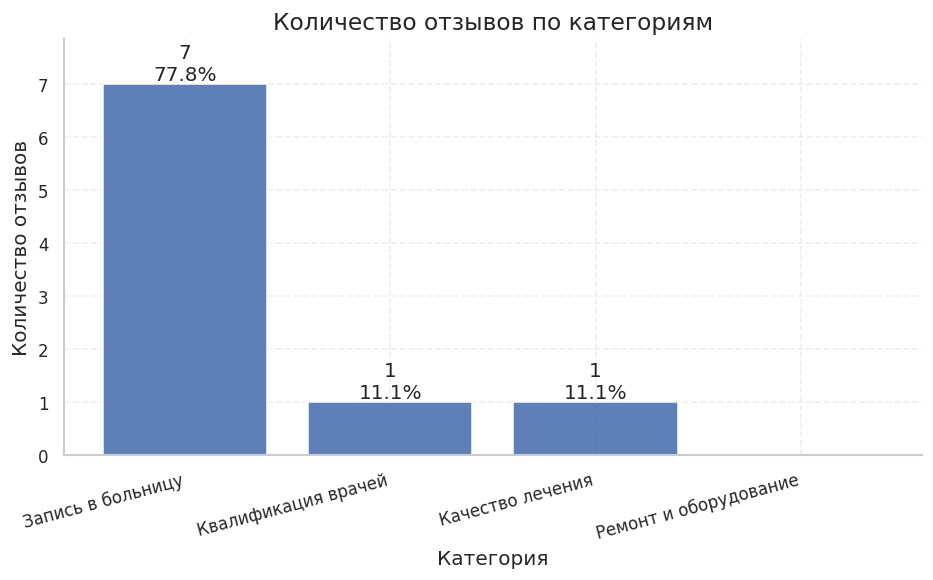

,category,count,percent
0,Запись в больницу,7,77.7800
1,Квалификация врачей,1,11.1100
2,Качество лечения,1,11.1100
3,Ремонт и оборудование,0,0.0000


Источник меток: df_top_hosp_neg_cls.topic. Всего учтено: 9. Лидирует: Запись в больницу (7).


In [25]:
# Задание 3.6 — график количества отзывов в каждой категории (фикс выравнивания меток)

def _norm_label(x: object) -> str:
    """
    Нормализовать имя метки для устойчивого сопоставления:
    - привести к нижнему регистру
    - схлопнуть подряд идущие пробелы
    - обрезать края
    """
    s = "" if x is None else str(x)
    return " ".join(s.lower().split())

# 1) подготовка: список меток в нужном порядке
labels = LABELS if "LABELS" in globals() else [
    "Запись в больницу",
    "Квалификация врачей",
    "Качество лечения",
    "Ремонт и оборудование",
]

# 2) выбираем источник меток на уровне ОТЗЫВА
counts_raw = None
source = ""

if "df_top_hosp_neg_cls" in globals() and isinstance(df_top_hosp_neg_cls, pd.DataFrame) and "topic" in df_top_hosp_neg_cls.columns:
    # прямые метки отзывов из шага 3.4 (убираем пустые/пробельные)
    s = df_top_hosp_neg_cls["topic"].dropna().astype(str).str.strip()
    s = s[s.ne("")]
    counts_raw = s.value_counts()
    source = "df_top_hosp_neg_cls.topic"

elif "segments_df" in globals() and isinstance(segments_df, pd.DataFrame) and {"row_id", "best_label", "best_score"}.issubset(segments_df.columns):
    # агрегируем: для каждого row_id берём метку с максимальным средним score
    tmp = segments_df.dropna(subset=["row_id", "best_label", "best_score"]).copy()
    tmp["best_label"] = tmp["best_label"].astype(str).str.strip()
    means = (
        tmp.groupby(["row_id", "best_label"])["best_score"]
           .mean()
           .reset_index()
    )
    idx = means.groupby("row_id")["best_score"].idxmax()
    top_labels = means.loc[idx, "best_label"]
    counts_raw = top_labels.value_counts()
    source = "segments_df (агрегация по среднему score)"

elif "label2sentences" in globals() and isinstance(label2sentences, dict):
    # fallback: считаем предложения (предупреждаем)
    print("⚠️ Нет меток на уровне отзывов. Считаю количество ПРЕДЛОЖЕНИЙ по категориям (fallback).")
    counts_raw = pd.Series({k: len(v) for k, v in label2sentences.items() if isinstance(v, list)})
    source = "label2sentences (предложения)"

else:
    raise NameError("Не найден источник категорий. Выполните 3.4 (df_top_hosp_neg_cls) или 3.5 (segments_df/label2sentences).")

# --- КЛЮЧЕВАЯ ЧАСТЬ: выравнивание меток ---
# нормализуем индексы counts_raw и канонические labels
counts_norm = counts_raw.copy()
counts_norm.index = counts_norm.index.map(_norm_label)
labels_norm = [_norm_label(x) for x in labels]

# аккуратно сопоставляем: суммируем метки, совпавшие после нормализации
aligned = pd.Series(0, index=labels_norm, dtype=int)
for k, v in counts_norm.items():
    if k in aligned.index:
        aligned[k] += int(v)

# восстановим «человеческие» подписи в исходном порядке
counts = pd.Series(aligned.values, index=labels, name="count")

# подсветим метки, которые не попали в канон
unmatched = sorted(set(counts_norm.index) - set(labels_norm))
if unmatched:
    print("⚠️ Внимание: обнаружены метки, отсутствующие в списке LABELS (не попали на график):")
    for u in unmatched[:10]:
        print("  •", u)
    if len(unmatched) > 10:
        print(f"  … и ещё {len(unmatched) - 10}")

# --- расчёт процентов/итогов ---
total = int(counts.sum())
perc = (counts / max(total, 1) * 100).round(2)

# 4) построение графика (используем ранее заданный стиль)
try:
    use_plot_style()
except NameError:
    plt.rcParams.update({
        "figure.figsize": (9, 5),
        "axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.3,
        "axes.titlesize": 14, "axes.labelsize": 12, "xtick.labelsize": 10, "ytick.labelsize": 10,
        "figure.dpi": 120,
    })
try:
    finalize_axes
except NameError:
    def finalize_axes(ax, title="", xlabel="", ylabel=""):
        ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)

fig, ax = plt.subplots()
ax.bar(range(len(labels)), counts.values, alpha=0.9)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=15, ha="right")

# запас сверху, чтобы не срезало подписи
ymax = counts.values.max() if len(counts) else 0
ax.set_ylim(0, ymax * 1.12 if ymax > 0 else 1)

finalize_axes(
    ax,
    title="Количество отзывов по категориям",
    xlabel="Категория",
    ylabel="Количество отзывов" if source != "label2sentences (предложения)" else "Количество предложений",
)

# аннотации на столбцах: шт. и %
for i, (v, p) in enumerate(zip(counts.values, perc.values)):
    if v > 0:
        ax.text(i, v, f"{int(v)}\n{p:.1f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()

# 5) компактная таблица и краткий вывод
result_df = pd.DataFrame({"category": counts.index, "count": counts.values, "percent": perc.values})
try:
    from IPython.display import display
    display(result_df)
except Exception:
    print(result_df.to_string(index=False))

lead_i = int(counts.values.argmax()) if total > 0 else 0
lead_cat = counts.index[lead_i]
lead_val = int(counts.iloc[lead_i]) if total > 0 else 0
print(f"Источник меток: {source}. Всего учтено: {total}. Лидирует: {lead_cat} ({lead_val}).")


In [26]:
# Задание 4.1 — минимальная загрузка модели
from transformers import AutoTokenizer

model_name = "facebook/xglm-7.5B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

print("OK:", model_name, "| tokenizer:", type(tokenizer).__name__)


OK: facebook/xglm-7.5B | tokenizer: XGLMTokenizerFast


In [28]:
# Задание 4.2 — безопасная загрузка с BitsAndBytesConfig (int8→int4; fallback на меньшую модель)

import sys, subprocess, torch, os, gc
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

def _ensure_bnb():
    """Проверить/установить bitsandbytes+accelerate без рестарта."""
    try:
        import bitsandbytes as bnb  # noqa
        return True
    except Exception:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                                   "bitsandbytes>=0.43.1", "accelerate>=0.30.0", "packaging"])
            import bitsandbytes as bnb  # noqa
            return True
        except Exception:
            return False

def _try_load(model_name, quant_cfg=None, use_gpu=torch.cuda.is_available()):
    """Попробовать загрузить модель с/без квантования."""
    kwargs = dict(low_cpu_mem_usage=True)
    if use_gpu:
        kwargs["device_map"] = "auto"
    if quant_cfg is not None:
        kwargs["quantization_config"] = quant_cfg
    else:
        kwargs["torch_dtype"] = torch.float16 if use_gpu else torch.float32
    try:
        model = AutoModelForCausalLM.from_pretrained(model_name, **kwargs).eval()
        return model, None
    except Exception as e:
        return None, e

# --- параметры ---
primary_model = "facebook/xglm-7.5B"
fallback_model = "facebook/xglm-2.9B"

# --- токенизатор ---
tokenizer = AutoTokenizer.from_pretrained(primary_model)
if tokenizer.pad_token is None and tokenizer.eos_token is not None:
    tokenizer.pad_token = tokenizer.eos_token

bnb_ok = _ensure_bnb()
model_name = primary_model
model = None
err = None

if torch.cuda.is_available() and bnb_ok:
    # 1) int8
    bnb8 = BitsAndBytesConfig(load_in_8bit=True, llm_int8_threshold=6.0, llm_int8_skip_modules=None)
    model, err = _try_load(model_name, bnb8)
    quant_mode = "int8"

    # 2) int4 (nf4), если int8 не взлетел
    if model is None:
        print("⚠️ int8 не удалось:", type(err).__name__, str(err)[:140])
        torch.cuda.empty_cache(); gc.collect()
        bnb4 = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16,
        )
        model, err = _try_load(model_name, bnb4)
        quant_mode = "int4 (nf4)"

    # 3) fallback на меньшую модель с int8
    if model is None:
        print("❗ Пробую более лёгкую модель:", fallback_model)
        model_name = fallback_model
        model, err = _try_load(model_name, bnb8)
        quant_mode = "int8 (fallback)"

# Если GPU нет или bnb не доступен — последний фолбэк: без квантования, меньшая модель
if model is None:
    if not torch.cuda.is_available():
        print("⚠️ GPU не обнаружен — загружу меньшую модель без квантования (для демонстрации).")
    elif not bnb_ok:
        print("⚠️ bitsandbytes недоступен — загружу меньшую модель без квантования (для демонстрации).")
    model_name = fallback_model
    model, err = _try_load(model_name, None, use_gpu=torch.cuda.is_available())
    quant_mode = "fp16" if torch.cuda.is_available() else "fp32"
    if model is None:
        raise RuntimeError(f"Не удалось загрузить модель: {type(err).__name__}: {err}")

# прогрев (безопасный)
try:
    inputs = tokenizer("warmup", return_tensors="pt").to(model.device)
    _ = model.generate(**inputs, max_new_tokens=1, do_sample=False)
except Exception:
    pass

print(f"✅ Загружено: {model_name} | режим: {quant_mode} | device: {next(model.parameters()).device} | dtype: {next(model.parameters()).dtype}")


⚠️ int8 не удалось: ValueError Some modules are dispatched on the CPU or the disk. Make sure you have enough GPU RAM to fit the quantized model. If you want to dispatch th
❗ Пробую более лёгкую модель: facebook/xglm-2.9B


RuntimeError: Не удалось загрузить модель: ValueError: The current `device_map` had weights offloaded to the disk. Please provide an `offload_folder` for them. Alternatively, make sure you have `safetensors` installed if the model you are using offers the weights in this format.

In [ ]:
# Алиас: в 4.2 модель называлась `model`. Делаем единое имя.
xglm_model = model

# Проверка, что квантование активно и на каком устройстве модель
print("8bit:", getattr(xglm_model, "is_loaded_in_8bit", False),
      "| 4bit:", getattr(xglm_model, "is_loaded_in_4bit", False),
      "| device:", next(xglm_model.parameters()).device)

# Доп. проверка: количество 8-битных линейных слоёв (если есть bitsandbytes)
try:
    import bitsandbytes as bnb
    n_8bit = sum(1 for m in xglm_model.modules() if isinstance(m, bnb.nn.Linear8bitLt))
    print("8-bit Linear layers:", n_8bit)
except Exception:
    pass


In [ ]:
# Задание 4.3 — генерация рекомендаций на основе объединённых негативных отзывов одной больницы
import pandas as pd
import torch
from typing import List

# --- маленькие помощники (без лишних импортов) ---

def _detect_name_column(df: pd.DataFrame) -> str:
    for c in ("name_ru","name","title_ru","title","org_name","place_name","hospital","clinic"):
        if c in df.columns:
            return c
    for c in df.columns:
        if df[c].dtype == "object":
            return c
    raise KeyError("Не найден столбец с названием больницы (например: 'name_ru', 'name').")

def _norm(s: object) -> str:
    x = "" if s is None else str(s)
    return " ".join(x.replace("\u00A0"," ").lower().split())

def _ensure_df_neg(df_in: pd.DataFrame, sentiment_col="sentiment") -> pd.DataFrame:
    if sentiment_col not in df_in.columns:
        raise KeyError("Нужен столбец 'sentiment'. Выполни задание 2.3, затем повтори 4.3.")
    s = pd.to_numeric(df_in[sentiment_col], errors="coerce")
    out = df_in.loc[s.isin([0,1,2])].copy()
    out[sentiment_col] = s.loc[out.index].astype("Int64")
    if out.empty:
        raise ValueError("Нет строк с sentiment ∈ {0,1,2}.")
    return out.reset_index(drop=True)

def _subset_top_hospital(df_neg: pd.DataFrame) -> pd.DataFrame:
    name_col = _detect_name_column(df_neg)
    df_neg = df_neg.copy()
    df_neg["_name_norm"] = df_neg[name_col].map(_norm)
    # считаем частоты и берём топ-1 нормализованное имя
    top_key = (df_neg["_name_norm"].value_counts().index[0])
    return df_neg[df_neg["_name_norm"].eq(top_key)].drop(columns=["_name_norm"])

def _pick_text_col(df: pd.DataFrame) -> str:
    for c in ("review_text","text","comment","body","content","message","description"):
        if c in df.columns:
            return c
    # фолбэк — любой объектный столбец, не похожий на имя/адрес/тему
    for c in df.columns:
        if df[c].dtype == "object" and c not in ("name","title","name_ru","address","topic"):
            return c
    raise KeyError("Не найден столбец с текстом отзывов (например: 'text').")

def _clean_piece(s: str, max_chars: int = 220) -> str:
    s = " ".join(str(s).split())
    return s[:max_chars]

def aggregate_reviews(df: pd.DataFrame, text_col: str, topic_col: str | None = "topic",
                      max_reviews_total: int = 120, max_chars_per_review: int = 200,
                      ensure_all_topics: bool = True) -> List[str]:
    texts = df[text_col].dropna().astype(str)
    if texts.empty:
        return []
    if topic_col in df.columns:
        groups = {k: v[text_col].dropna().astype(str).tolist() for k, v in df.groupby(topic_col)}
        topics = [t for t in groups.keys() if str(t).strip() != ""]
        k = len(topics) if ensure_all_topics and topics else 1
        base_per_topic = max_reviews_total // max(1, k)
        frags = []
        for t in topics:
            frags.extend(_clean_piece(x, max_chars_per_review) for x in groups[t][:base_per_topic] if x.strip())
        rest = max_reviews_total - len(frags)
        if rest > 0:
            frags.extend(_clean_piece(x, max_chars_per_review) for x in texts.tolist()[:rest] if x.strip())
    else:
        frags = [_clean_piece(x, max_chars_per_review) for x in texts.head(max_reviews_total) if x.strip()]
    # убираем дубли
    seen, uniq = set(), []
    for f in frags:
        if f not in seen:
            seen.add(f); uniq.append(f)
    return uniq

def build_prompt(fragments: List[str], k: int = 6) -> str:
    bullet_block = "\n- " + "\n- ".join(fragments)
    return (
        "Ты — консультант по повышению качества медицинских услуг. "
        "Ниже объединены жалобы пациентов одной больницы из разных категорий. "
        "На их основе сформулируй конкретные, выполнимые рекомендации по улучшению работы.\n\n"
        "Фрагменты отзывов:\n"
        f"{bullet_block}\n\n"
        f"Сформулируй {k} рекомендаций. Каждая строка — короткое действие (глагол в начале), без общих фраз и канцелярита."
    )

def _get_model_and_tokenizer():
    tok = globals().get("tokenizer", None)
    mdl = globals().get("model", None) or globals().get("xglm_model", None)
    if tok is None or mdl is None:
        raise NameError("Не найдены tokenizer/model. Сначала выполни 4.2 (загрузка модели).")
    return tok, mdl

def _model_max_ctx(model, default_ctx: int = 2048) -> int:
    cfg = getattr(model, "config", None)
    for key in ("max_position_embeddings","n_positions","seq_length"):
        if cfg is not None and hasattr(cfg, key):
            val = int(getattr(cfg, key))
            if val > 0:
                return val
    return default_ctx

# --- 1) подготавливаем источник «одна больница» ---
src_name = None
df_src = None

# (а) если уже есть готовые срезы:
cand = globals().get("df_top_hosp_neg_cls", None)
if isinstance(cand, pd.DataFrame) and not cand.empty:
    df_src, src_name = cand, "df_top_hosp_neg_cls"
else:
    cand = globals().get("df_top_hosp_neg", None)
    if isinstance(cand, pd.DataFrame) and not cand.empty:
        df_src, src_name = cand, "df_top_hosp_neg"
    else:
        # (б) пересоберём из df_neg или df_hosp_msk/df
        base = globals().get("df_neg", None)
        if not isinstance(base, pd.DataFrame) or base.empty:
            base = globals().get("df_hosp_msk", None)
            if not isinstance(base, pd.DataFrame) or base.empty:
                base = globals().get("df", None)
        if not isinstance(base, pd.DataFrame) or base.empty:
            raise NameError("Не найден ни df_top_hosp_neg_cls, ни df_top_hosp_neg, ни df_neg, ни df/df_hosp_msk.")
        base_neg = _ensure_df_neg(base, "sentiment")
        df_src = _subset_top_hospital(base_neg)
        src_name = "reconstructed_from_df[_hosp_msk]"

# --- 2) собираем объединённый контекст ---
text_col = _pick_text_col(df_src)
fragments = aggregate_reviews(df_src, text_col=text_col, topic_col="topic",
                              max_reviews_total=120, max_chars_per_review=200, ensure_all_topics=True)
if not fragments:
    raise ValueError("Нет текстов для генерации — проверь источник отзывов.")

prompt = build_prompt(fragments, k=6)

# --- 3) генерация ---
tokenizer, xglm_model = _get_model_and_tokenizer()
ctx_len = _model_max_ctx(xglm_model, 2048)
max_new = 220
max_input = max(256, ctx_len - max_new - 32)

inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=max_input).to(xglm_model.device)
with torch.inference_mode():
    gen_ids = xglm_model.generate(
        **inputs,
        max_new_tokens=max_new,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.15,
        pad_token_id=tokenizer.pad_token_id or tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
output_text = tokenizer.decode(gen_ids[0], skip_special_tokens=True)

# оставим для постобработки:
gen_only = output_text[len(prompt):].strip()

print("Источник отзывов:", src_name, "| текстовая колонка:", text_col, f"| фрагментов: {len(fragments)}")
print("\n=== РЕКОМЕНДАЦИИ (генерация) ===")
print(gen_only if gen_only else output_text)

